In [21]:
import plotly.offline as pyo
pyo.init_notebook_mode()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2 
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn import preprocessing
import random
import tensorflow as tf
import warnings
import pydicom as dicom
import os
import numpy
from matplotlib import pyplot, cm
warnings.filterwarnings("ignore")
!pip install visualkeras

In [22]:
!pip install pydicom

In [23]:
X = np.load('../input/brain-tumor/Brain_tumorDATA/X.npy')
Y = np.load('../input/brain-tumor/Brain_tumorDATA/Y.npy')

KeyboardInterrupt: 

In [ ]:
X.shape,Y.shape

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.2)
print('Train data    :'+str(X_train.shape))
print('Test data     :'+str(X_test.shape))
print('Train Output  :'+str(y_train.shape))
print('Test Output   :'+str(y_test.shape))

In [ ]:
models_name = ['../input/mri-nlp/ComparitiveModels/Dense/BT_DENSE169',
             '../input/mri-nlp/ComparitiveModels/EfficientNetB7/BT_EfficientNetB7',
             '../input/mri-nlp/ComparitiveModels/ResNet50/BT_ResNet50',
             '../input/mri-nlp/Hybrid/Hybrid_EXP+RESNET/BT_Hybrid_EXP+RES',
             '../input/mri-nlp/Hybrid/Hybrid_EXP+Vgg/BT_Hybrid_EXP+VGG16'
            ]
models_f1 = []

In [ ]:
import pandas as pd
from tqdm import tqdm
from tensorflow.keras.models import model_from_json
for name in tqdm(models_name):
    json_file = open(name+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(name+'.h5')
    models_f1.append(loaded_model)
    print("Loaded model from disk  =  "+name)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import  metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import model_selection
from sklearn.metrics import accuracy_score, log_loss
import sklearn
import string
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import roc_curve, auc, roc_auc_score,accuracy_score,confusion_matrix
import warnings
warnings.filterwarnings("ignore")
def onevsall(y_true,y_pred,mod):
    
    
    global rdf
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    acc = (tp+tn)/(tp+tn+fp+fn)
    pre = tp/(tp+fp)
    rec = tp/(tp+fn)
    f1 = 2*rec*pre / (rec +pre)
    sp = tn / (tn +fp)
    #print('Done for '+mod)
    rdf=rdf.append({
            'Model':mod,
            'TN':tn,'FP':fp,'FN':fn,'TP':tp,
            'Accuracy':acc,
            'Precision':pre,
            'Recall or Sensitivity':rec,
            'F1 Score':f1,
            'Specificity':sp
        },ignore_index=True)
        
    return rdf

def roc(clf,x,y):
    import scikitplot as skplt
    import matplotlib.pyplot as plt
    skplt.metrics.plot_roc_curve(clf,x,y)
    plt.savefig('ROC'+model_name+'.jpg')
    plt.show()
    
def visualise(y_true,y_pred,name,model_name):
    ConfusionM = confusion_matrix(y_true,y_pred)

    #print('ROC AUC score:', 
    #multiclass_roc_auc_score(y_true,y_pred, ))
    print(classification_report(y_true,y_pred,   digits=4))
    print()
    return onevsall(y_true,y_pred,model_name)

In [ ]:
Y_op = map( lambda x: np.argmax(x)  ,Y)
Y_op = list(Y_op)

In [ ]:
for i in models_f1:
    METRICS = [
                'accuracy',
                tf.keras.metrics.BinaryAccuracy(name = 'BinaryAccuracy'),
                tf.keras.metrics.Precision(name ='Precision'),
                tf.keras.metrics.Recall(name ='Recall'),
                tf.keras.metrics.FalseNegatives(name ='FN'),
                tf.keras.metrics.FalsePositives(name ='FP'),
                tf.keras.metrics.TrueNegatives(name ='TN'),
                tf.keras.metrics.TruePositives(name ='TP'),
                tf.keras.metrics.AUC(name ='AUC')
    
        ]  
    i.compile(
                optimizer='Adam',
                loss='categorical_crossentropy',
                metrics=METRICS
            )

In [ ]:
from sklearn.model_selection import ShuffleSplit
from tqdm import tqdm
montecarlo_rns = ShuffleSplit(n_splits=20, test_size=0.20, random_state=0)
j = 1
montedf = pd.DataFrame()
for a, b in tqdm(montecarlo_rns.split(X)):
    X_t = X[a]
    Y_t = Y[a]
    
    rdf = pd.DataFrame()
    names = ['BT_DENSE169','BT_EfficientNetB7','BT_ResNet50','Hybrid_EXP+RES','Hybrid_EXP+VGG16']
    k= 0
    for clf in models_f1:
        score  = clf.evaluate(X_t,Y_t, verbose=1)
        dscore ={}
        for i in range(len(score)):
            dscore[clf.metrics_names[i]] = score[i]
        dscore['Model'] = names[k]
        rdf = rdf.append(dscore,ignore_index=True)
        k = k + 1
    rdf['Monte_Carlo_iteration']='Iteration_'+str(j)
    montedf = pd.concat([montedf,rdf])
    j = j + 1

In [44]:
print(montedf.shape)
montedf = montedf.reset_index(drop=True)
montedf.to_csv('BL__50_CV_DL.csv',index=False)
montedf

(100, 12)


loss  accuracy  BinaryAccuracy  Precision    Recall     FN      FP  \
0   0.070942  0.970959        0.940285   0.855670  0.987404   72.0   952.0   
1   0.467227  0.829601        0.807033   0.641008  0.957138  245.0  3064.0   
2   0.075091  0.977957        0.957838   0.894454  0.990378   55.0   668.0   
3   0.107698  0.966935        0.934336   0.846258  0.981281  107.0  1019.0   
4   0.092603  0.973408        0.973583   0.939536  0.984080   91.0   362.0   
..       ...       ...             ...        ...       ...    ...     ...   
95  0.076432  0.969209        0.939585   0.854223  0.987229   73.0   963.0   
96  0.465010  0.831001        0.807499   0.641179  0.959412  232.0  3069.0   
97  0.070063  0.978307        0.958596   0.895919  0.990903   52.0   658.0   
98  0.100518  0.966585        0.935619   0.848971  0.981456  106.0   998.0   
99  0.092844  0.973408        0.973699   0.939556  0.984430   89.0   362.0   

         TN      TP       AUC              Model Monte_Carlo_iteration  
0   10480.0  5644.0  0.996804        BT_DENSE169           Iteration_1  
1    8368.0  5471.0  0.953278  BT_EfficientNetB7           Iteration_1  
2   10764.0  5661.0  0.996224        BT_ResNet50           Iteration_1  
3   10413.0  5609.0  0.993955     Hybrid_EXP+RES           Iteration_1  
4   11070.0  5625.0  0.996188   Hybrid_EXP+VGG16           Iteration_1  
..      ...     ...       ...                ...                   ...  
95  10469.0  5643.0  0.996540        BT_DENSE169          Iteration_20  
96   8363.0  5484.0  0.953233  BT_EfficientNetB7          Iteration_20  
97  10774.0  5664.0  0.996433        BT_ResNet50          Iteration_20  
98  10434.0  5610.0  0.994220     Hybrid_EXP+RES          Iteration_20  
99  11070.0  5627.0  0.996168   Hybrid_EXP+VGG16          Iteration_20  

[100 rows x 12 columns]

In [41]:
for i in names:
    print(montedf[montedf['Model']==i].describe())
    montedf[montedf['Model']==i].to_csv(i+'.csv',index=False)

            loss   accuracy  BinaryAccuracy  Precision     Recall         FN  \
count  20.000000  20.000000       20.000000  20.000000  20.000000  20.000000   
mean    0.075156   0.969515        0.939897   0.855150   0.986853  75.150000   
std     0.002450   0.000943        0.000728   0.001589   0.000551   3.150188   
min     0.070942   0.967985        0.938535   0.852115   0.985829  71.000000   
25%     0.073245   0.968991        0.939541   0.854304   0.986617  73.000000   
50%     0.075330   0.969384        0.939847   0.855182   0.986966  74.500000   
75%     0.076332   0.970171        0.940197   0.855718   0.987229  76.500000   
max     0.080868   0.970959        0.941509   0.858512   0.987579  81.000000   

               FP            TN           TP        AUC  
count   20.000000     20.000000    20.000000  20.000000  
mean   955.500000  10476.500000  5640.850000   0.996600  
std     12.283922     12.283922     3.150188   0.000119  
min    930.000000  10453.000000  5635.000000   

In [43]:
op= montedf[montedf['Model']!='BT_EfficientNetB7']

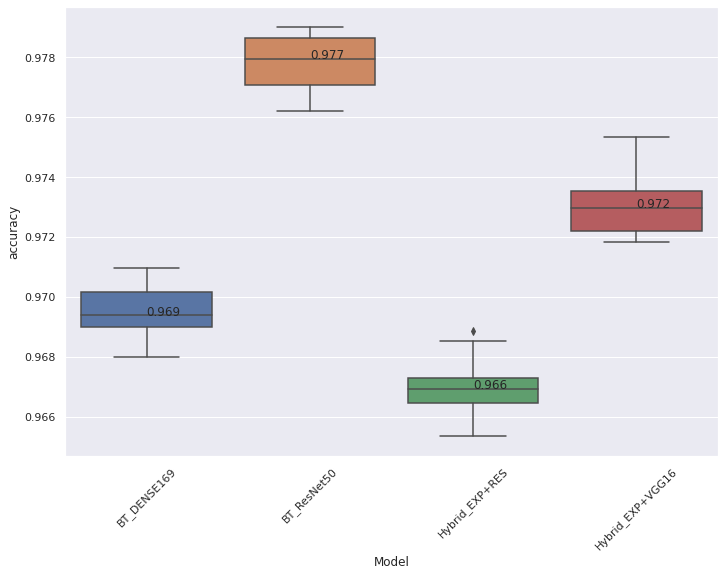

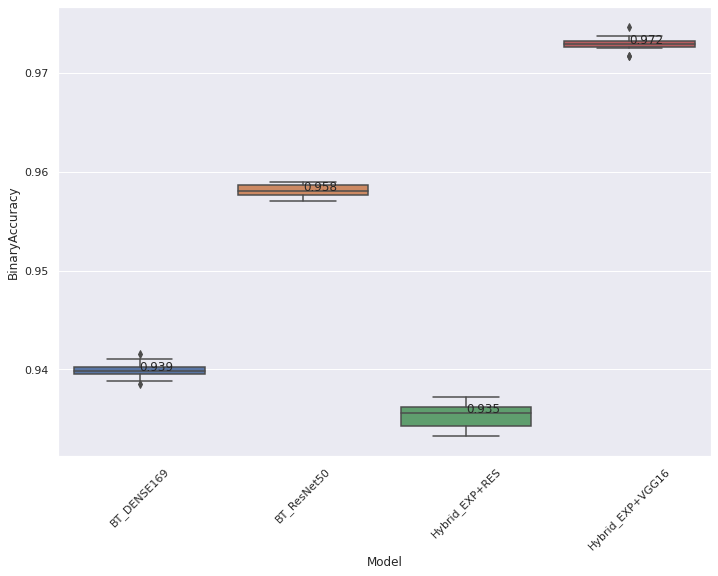

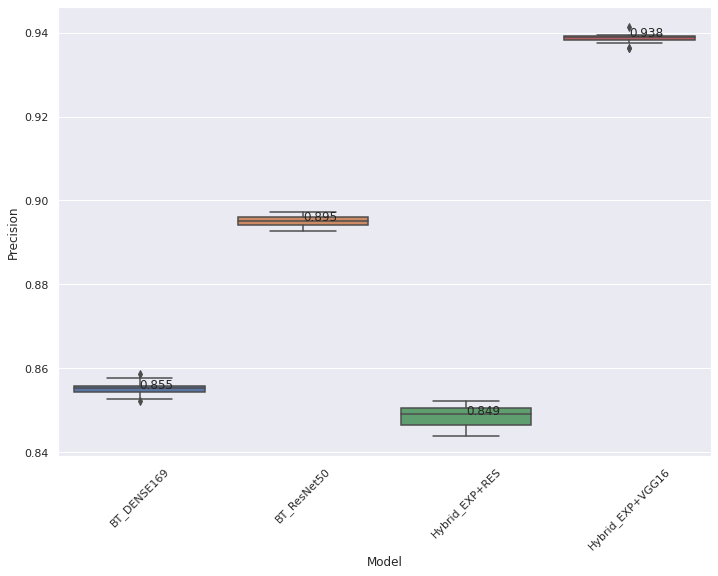

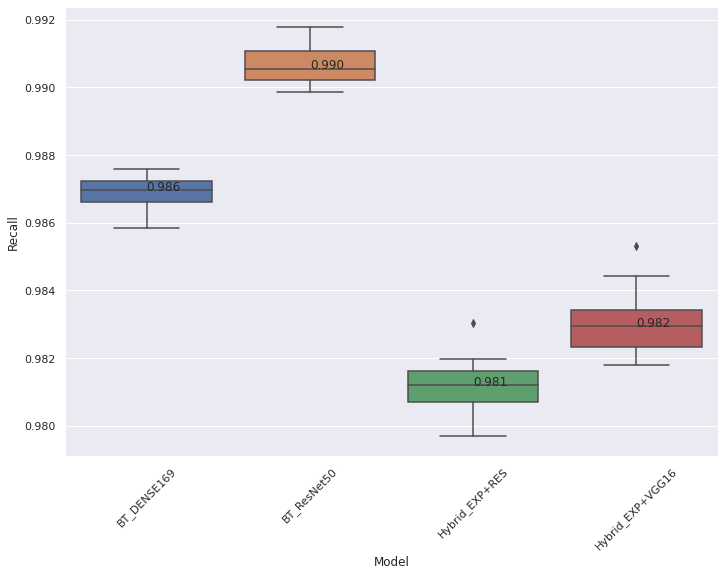

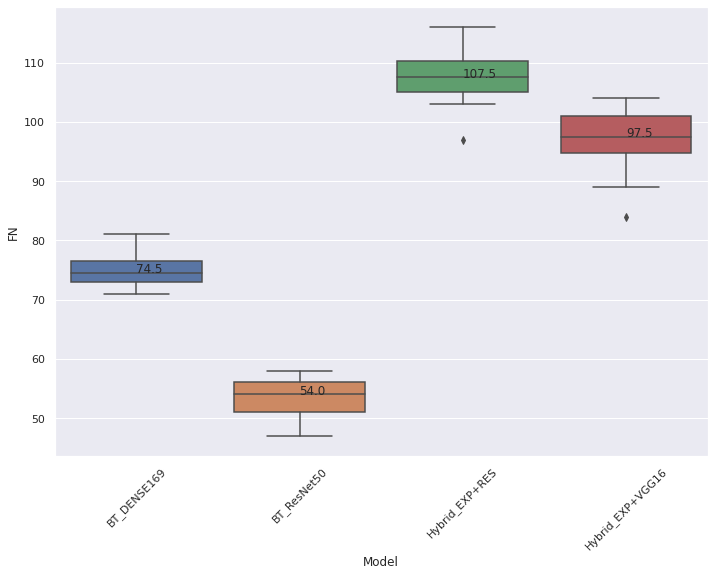

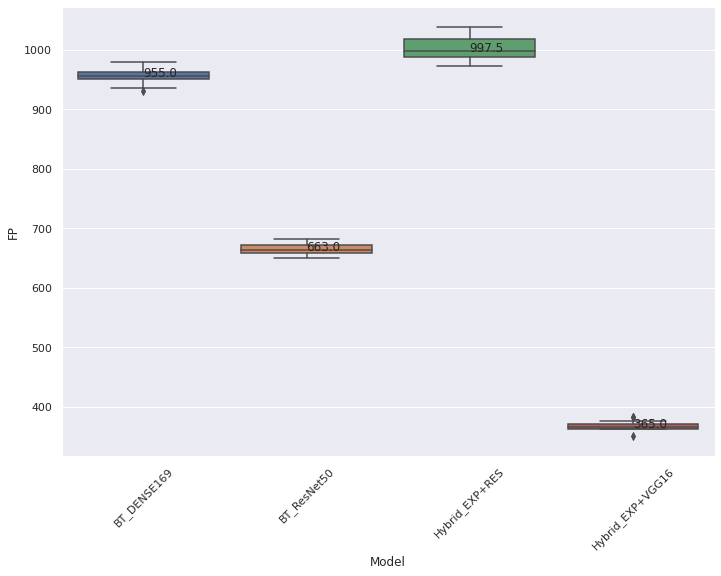

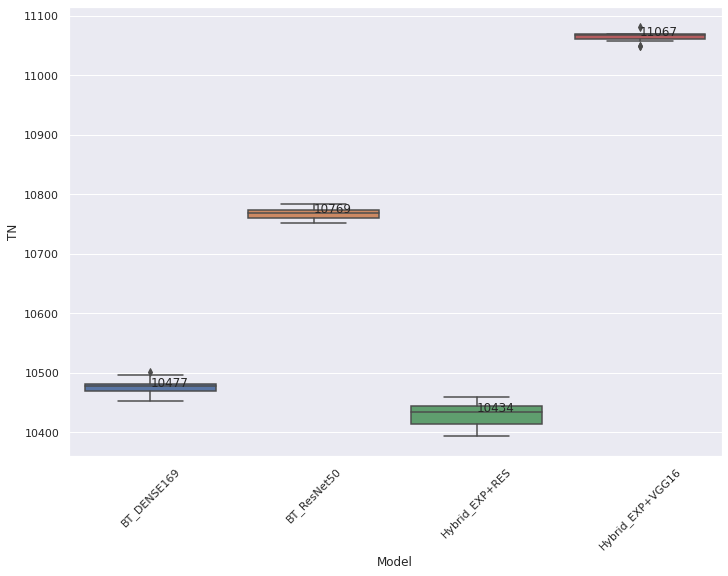

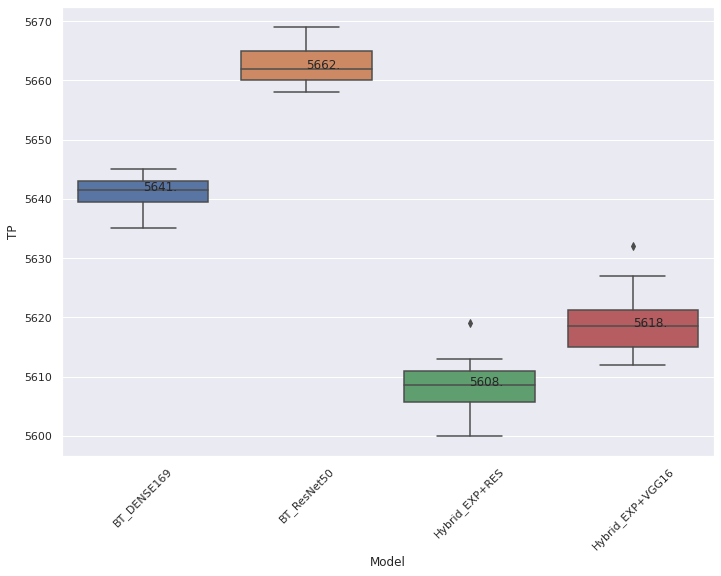

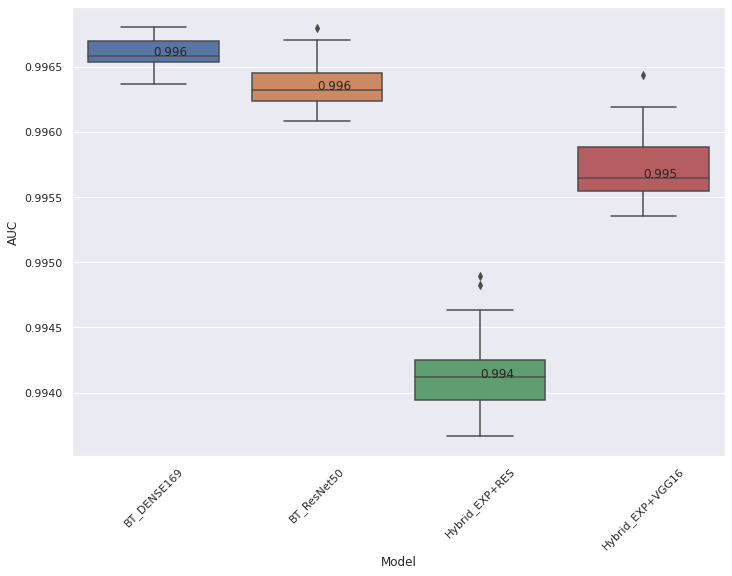

In [40]:
import seaborn as sns

sns.set(rc={'figure.figsize':(11.7,8.27)})
for param in ['accuracy', 'BinaryAccuracy', 'Precision', 'Recall', 'FN', 'FP', 'TN', 'TP', 'AUC'
]:
    monteX = op.sort_values(by=['Model'], ascending=False)
    medians = monteX.groupby(['Model'])[param].median().reset_index()
    Order = list(medians['Model'])
    box = sns.boxplot(x="Model", y=param,order = Order,
                     data=op, linewidth=1.5)
    for i in range(len(medians[param])):
        box.annotate(str(medians.iloc[i][param])[:5],xy = (i,medians.iloc[i][param]))
    plt.xticks(rotation=45)
    plt.savefig('WE__CV_mean_'+param+'.jpg')
    plt.show()
    

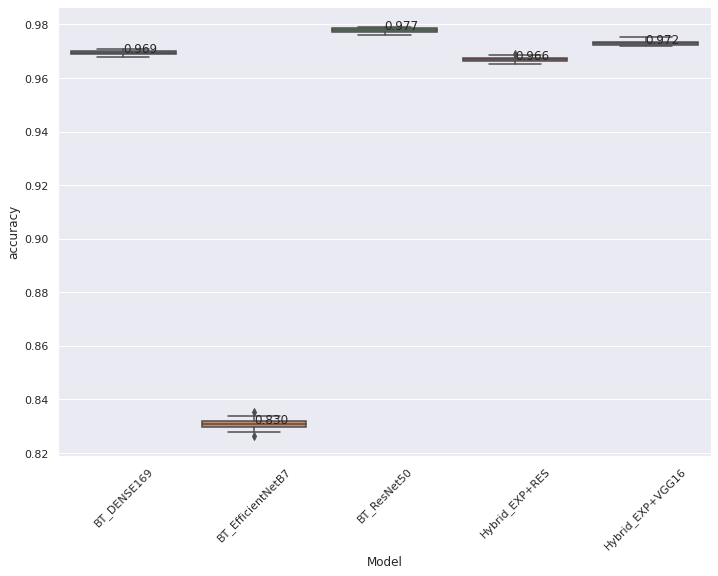

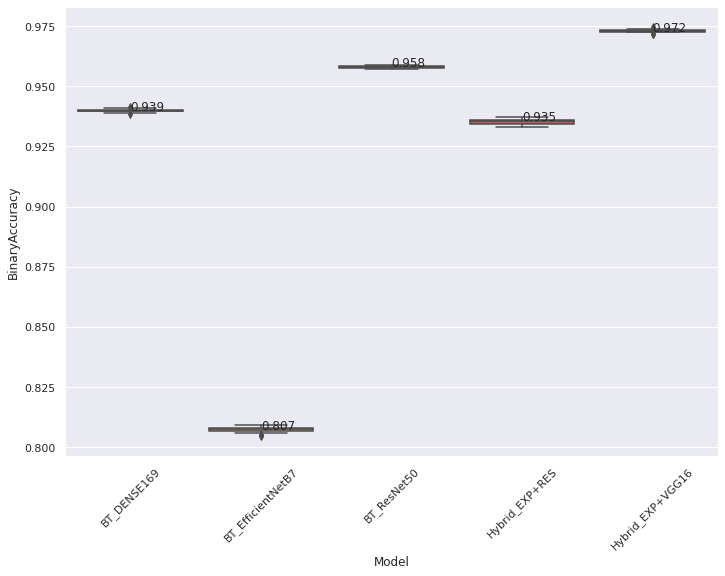

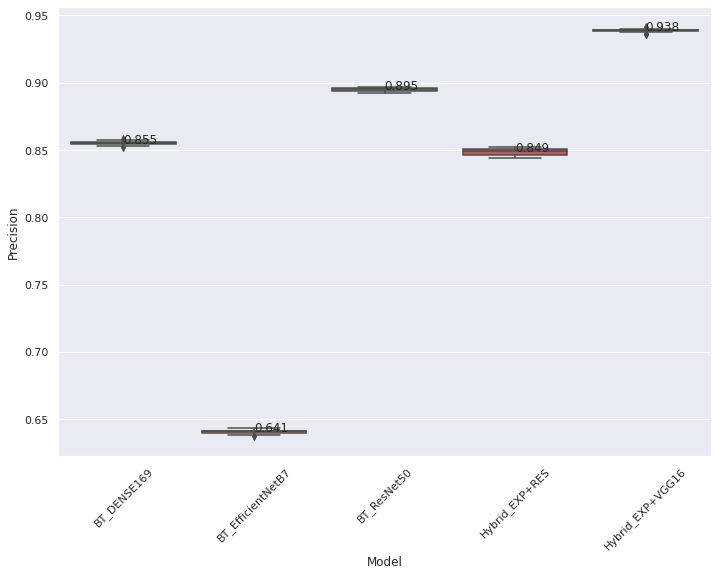

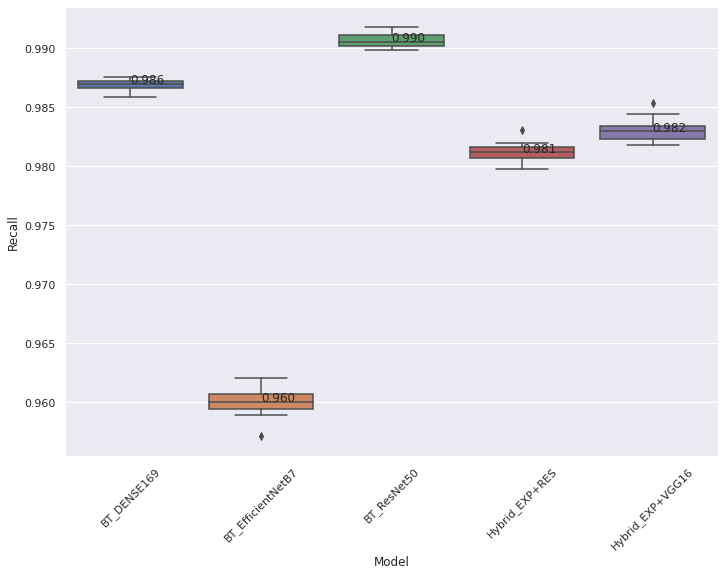

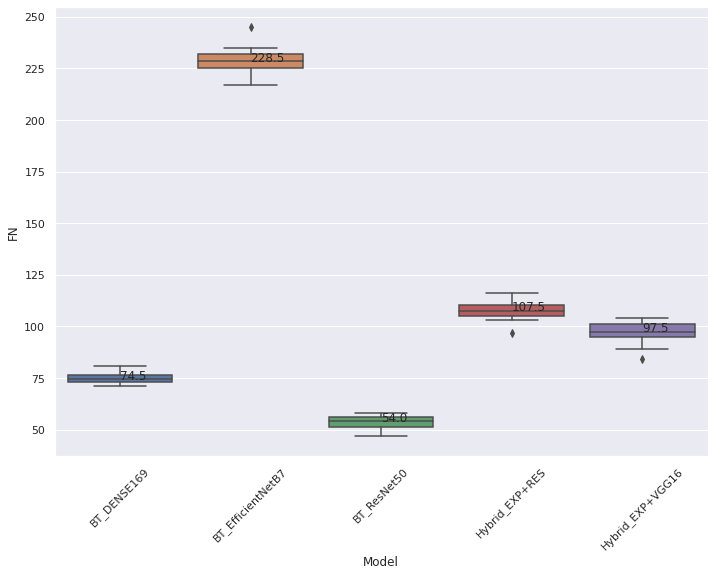

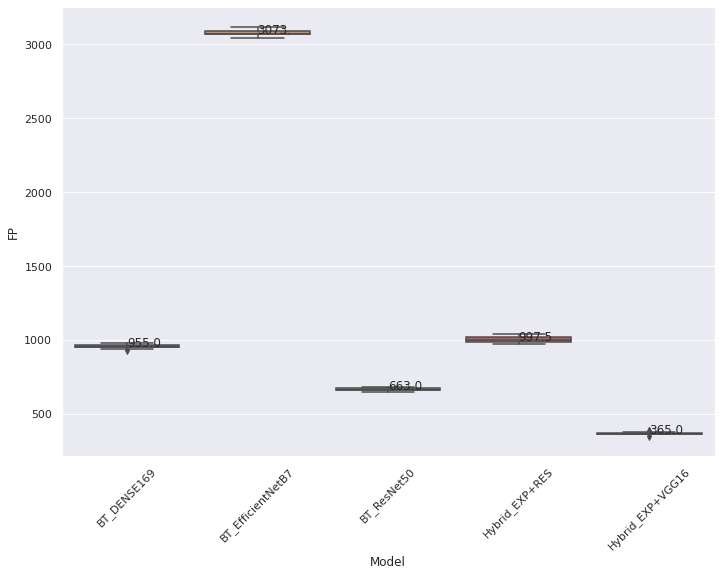

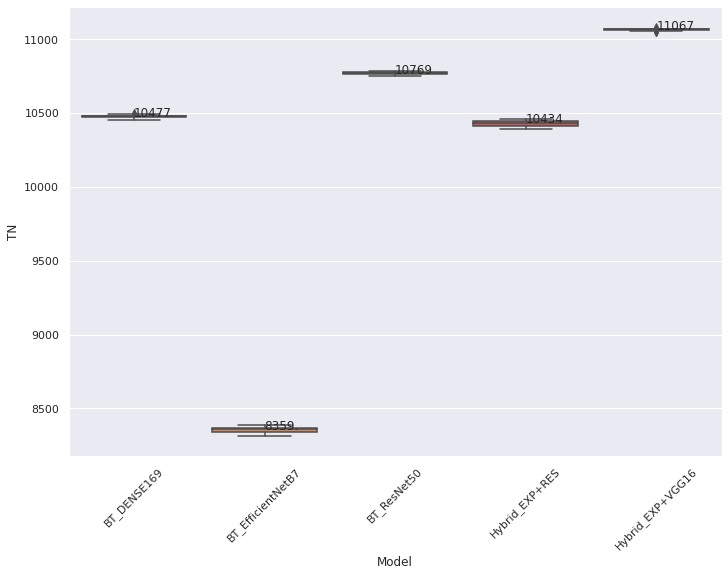

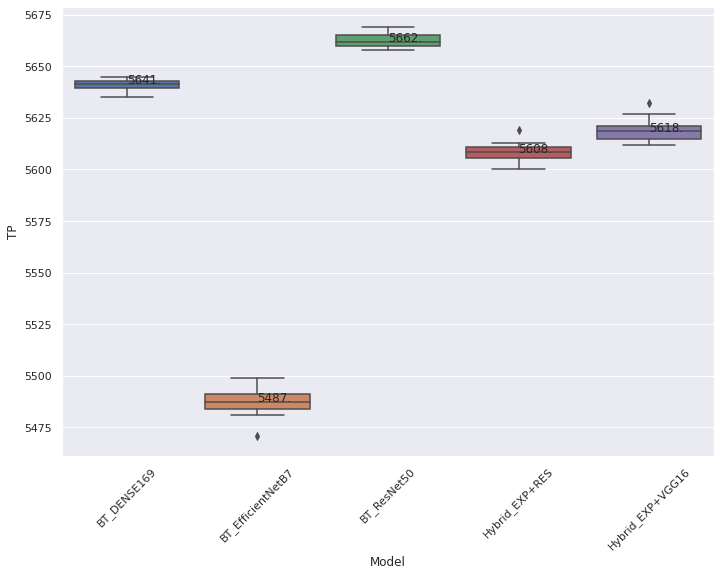

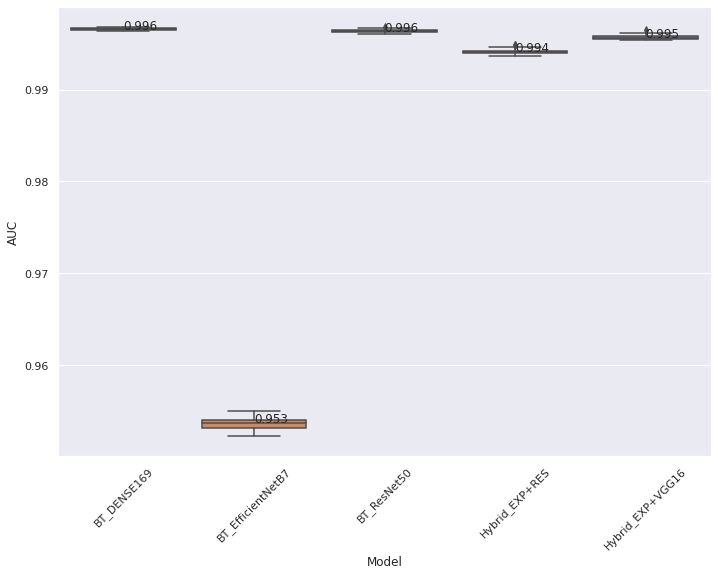

In [39]:
import seaborn as sns

sns.set(rc={'figure.figsize':(11.7,8.27)})
for param in ['accuracy', 'BinaryAccuracy', 'Precision', 'Recall', 'FN', 'FP', 'TN', 'TP', 'AUC'
]:
    monteX = montedf.sort_values(by=['Model'], ascending=False)
    medians = monteX.groupby(['Model'])[param].median().reset_index()
    Order = list(medians['Model'])
    box = sns.boxplot(x="Model", y=param,order = Order,
                     data=montedf, linewidth=1.5)
    for i in range(len(medians[param])):
        box.annotate(str(medians.iloc[i][param])[:5],xy = (i,medians.iloc[i][param]))
    plt.xticks(rotation=45)
    plt.savefig('CV_mean_'+param+'.jpg')
    plt.show()

In [26]:
max(montedf[param])

0.9968041777610779

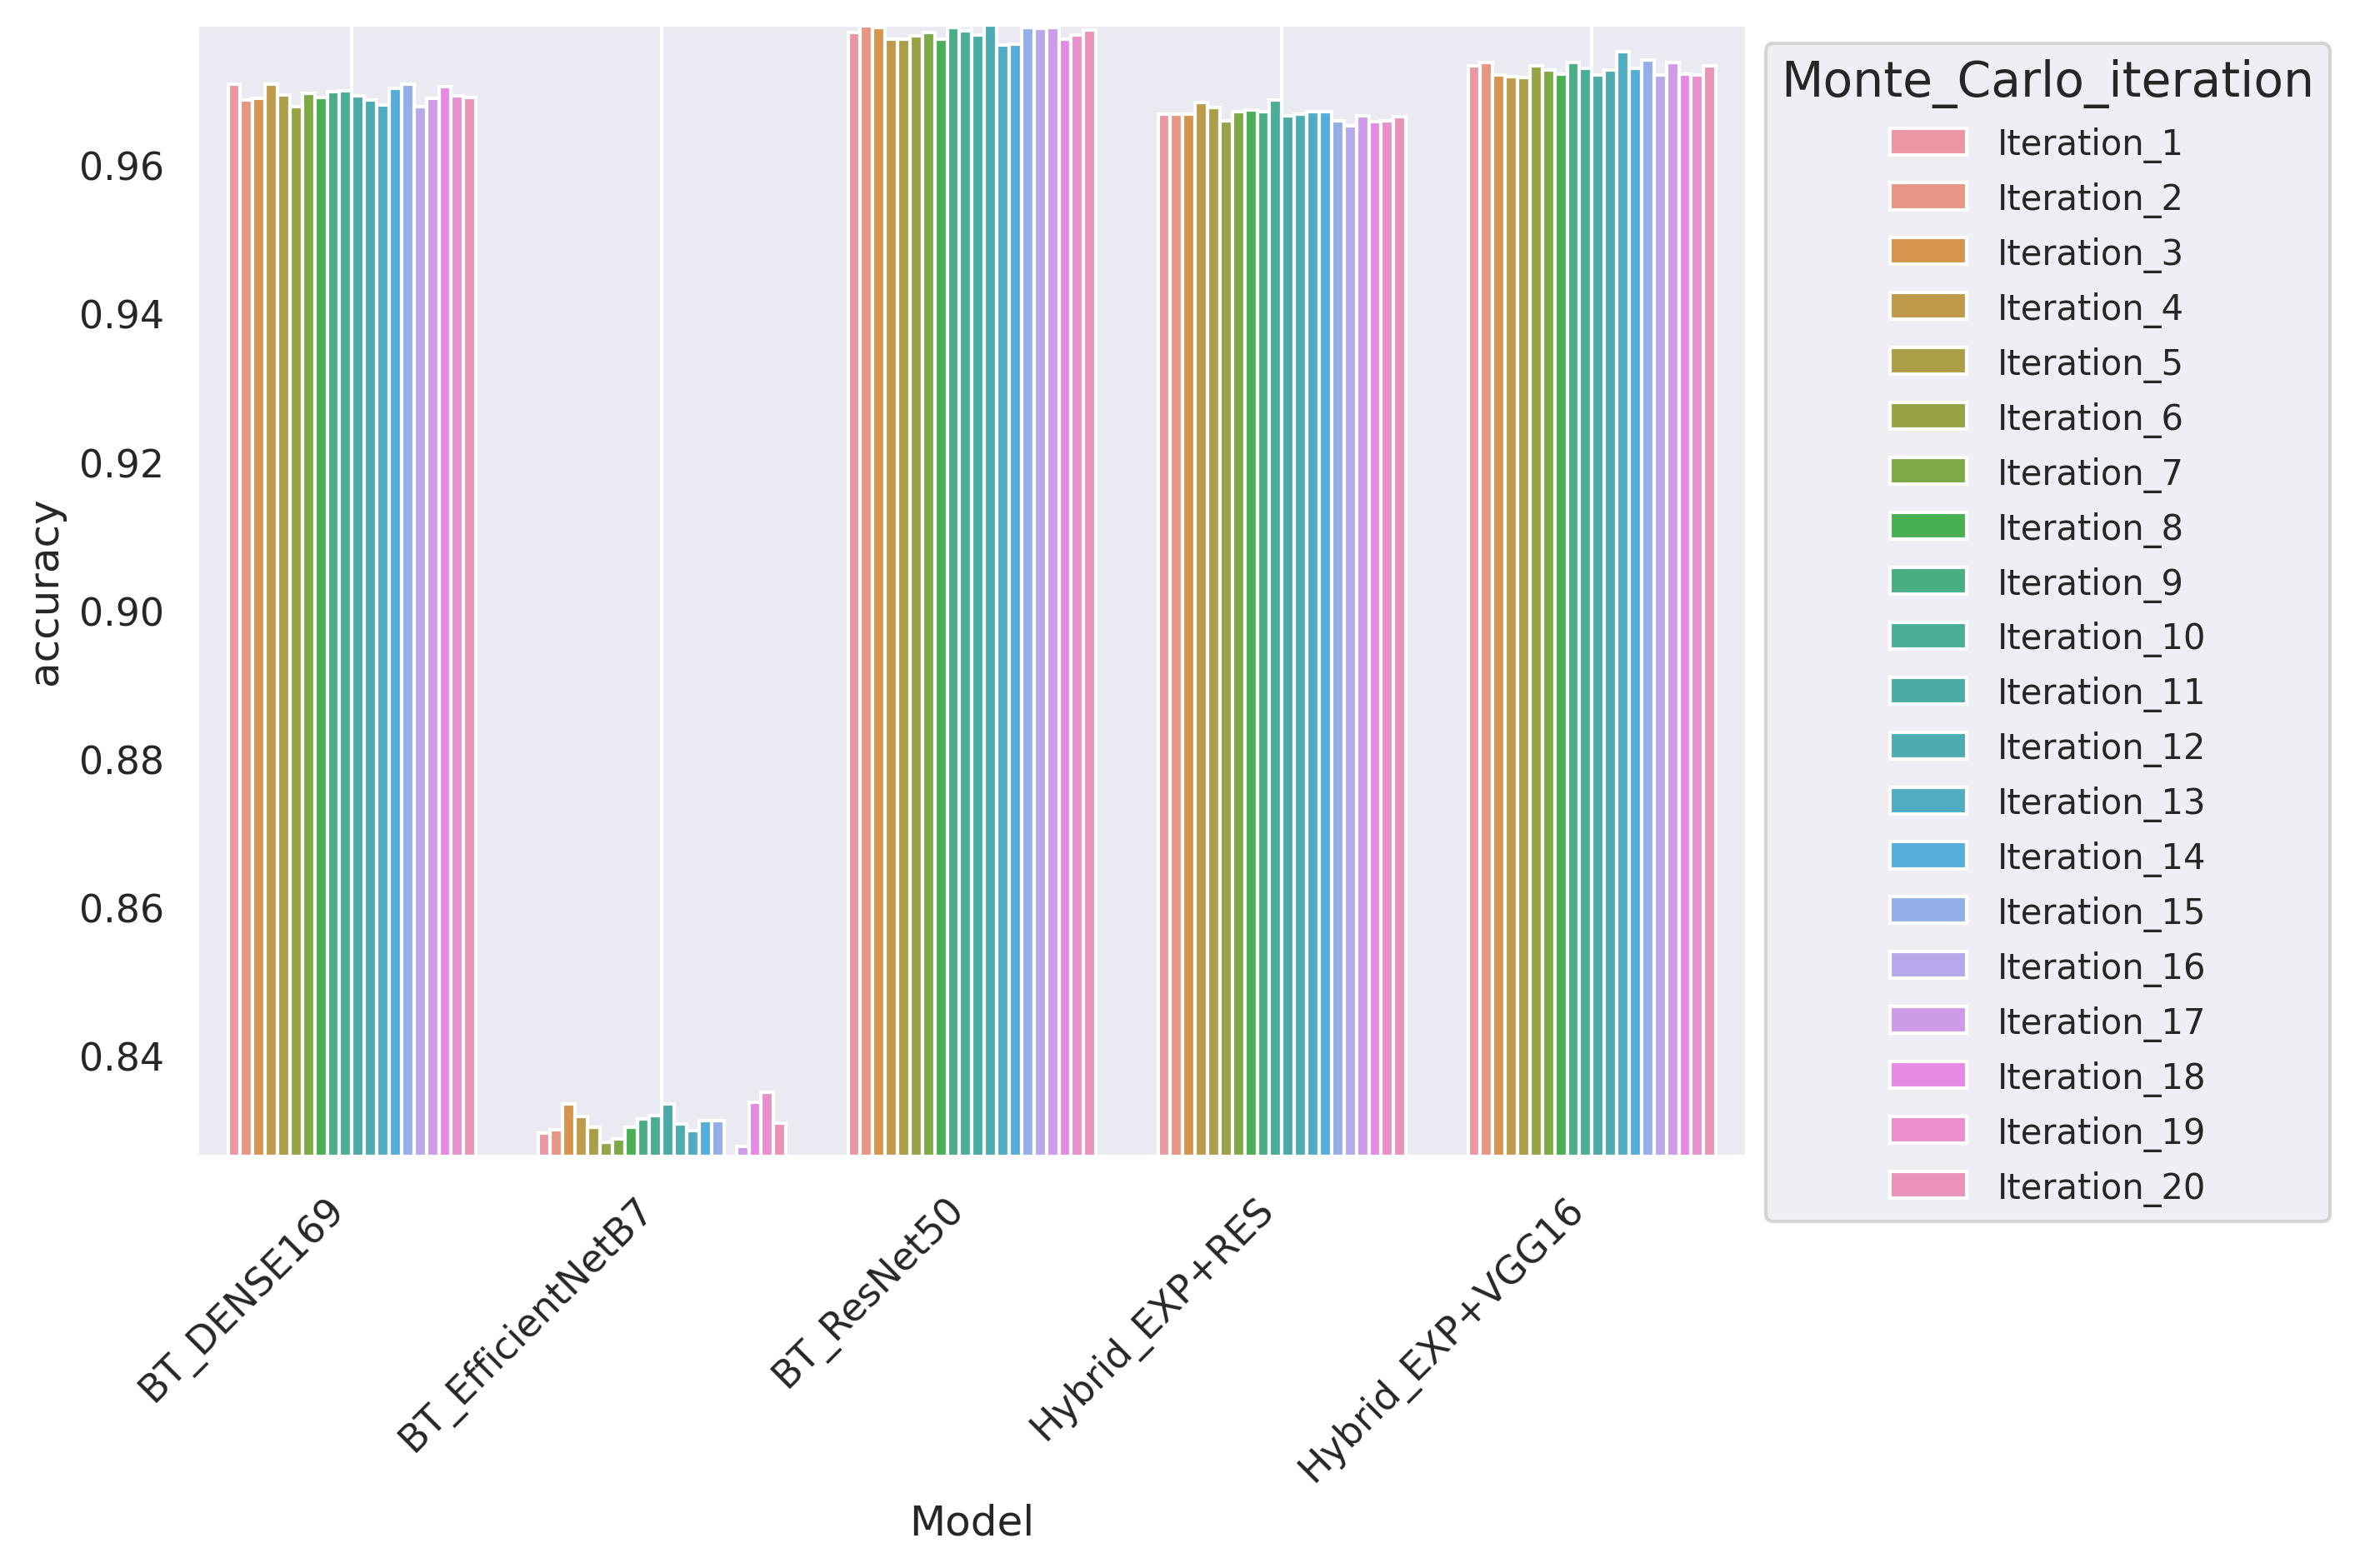

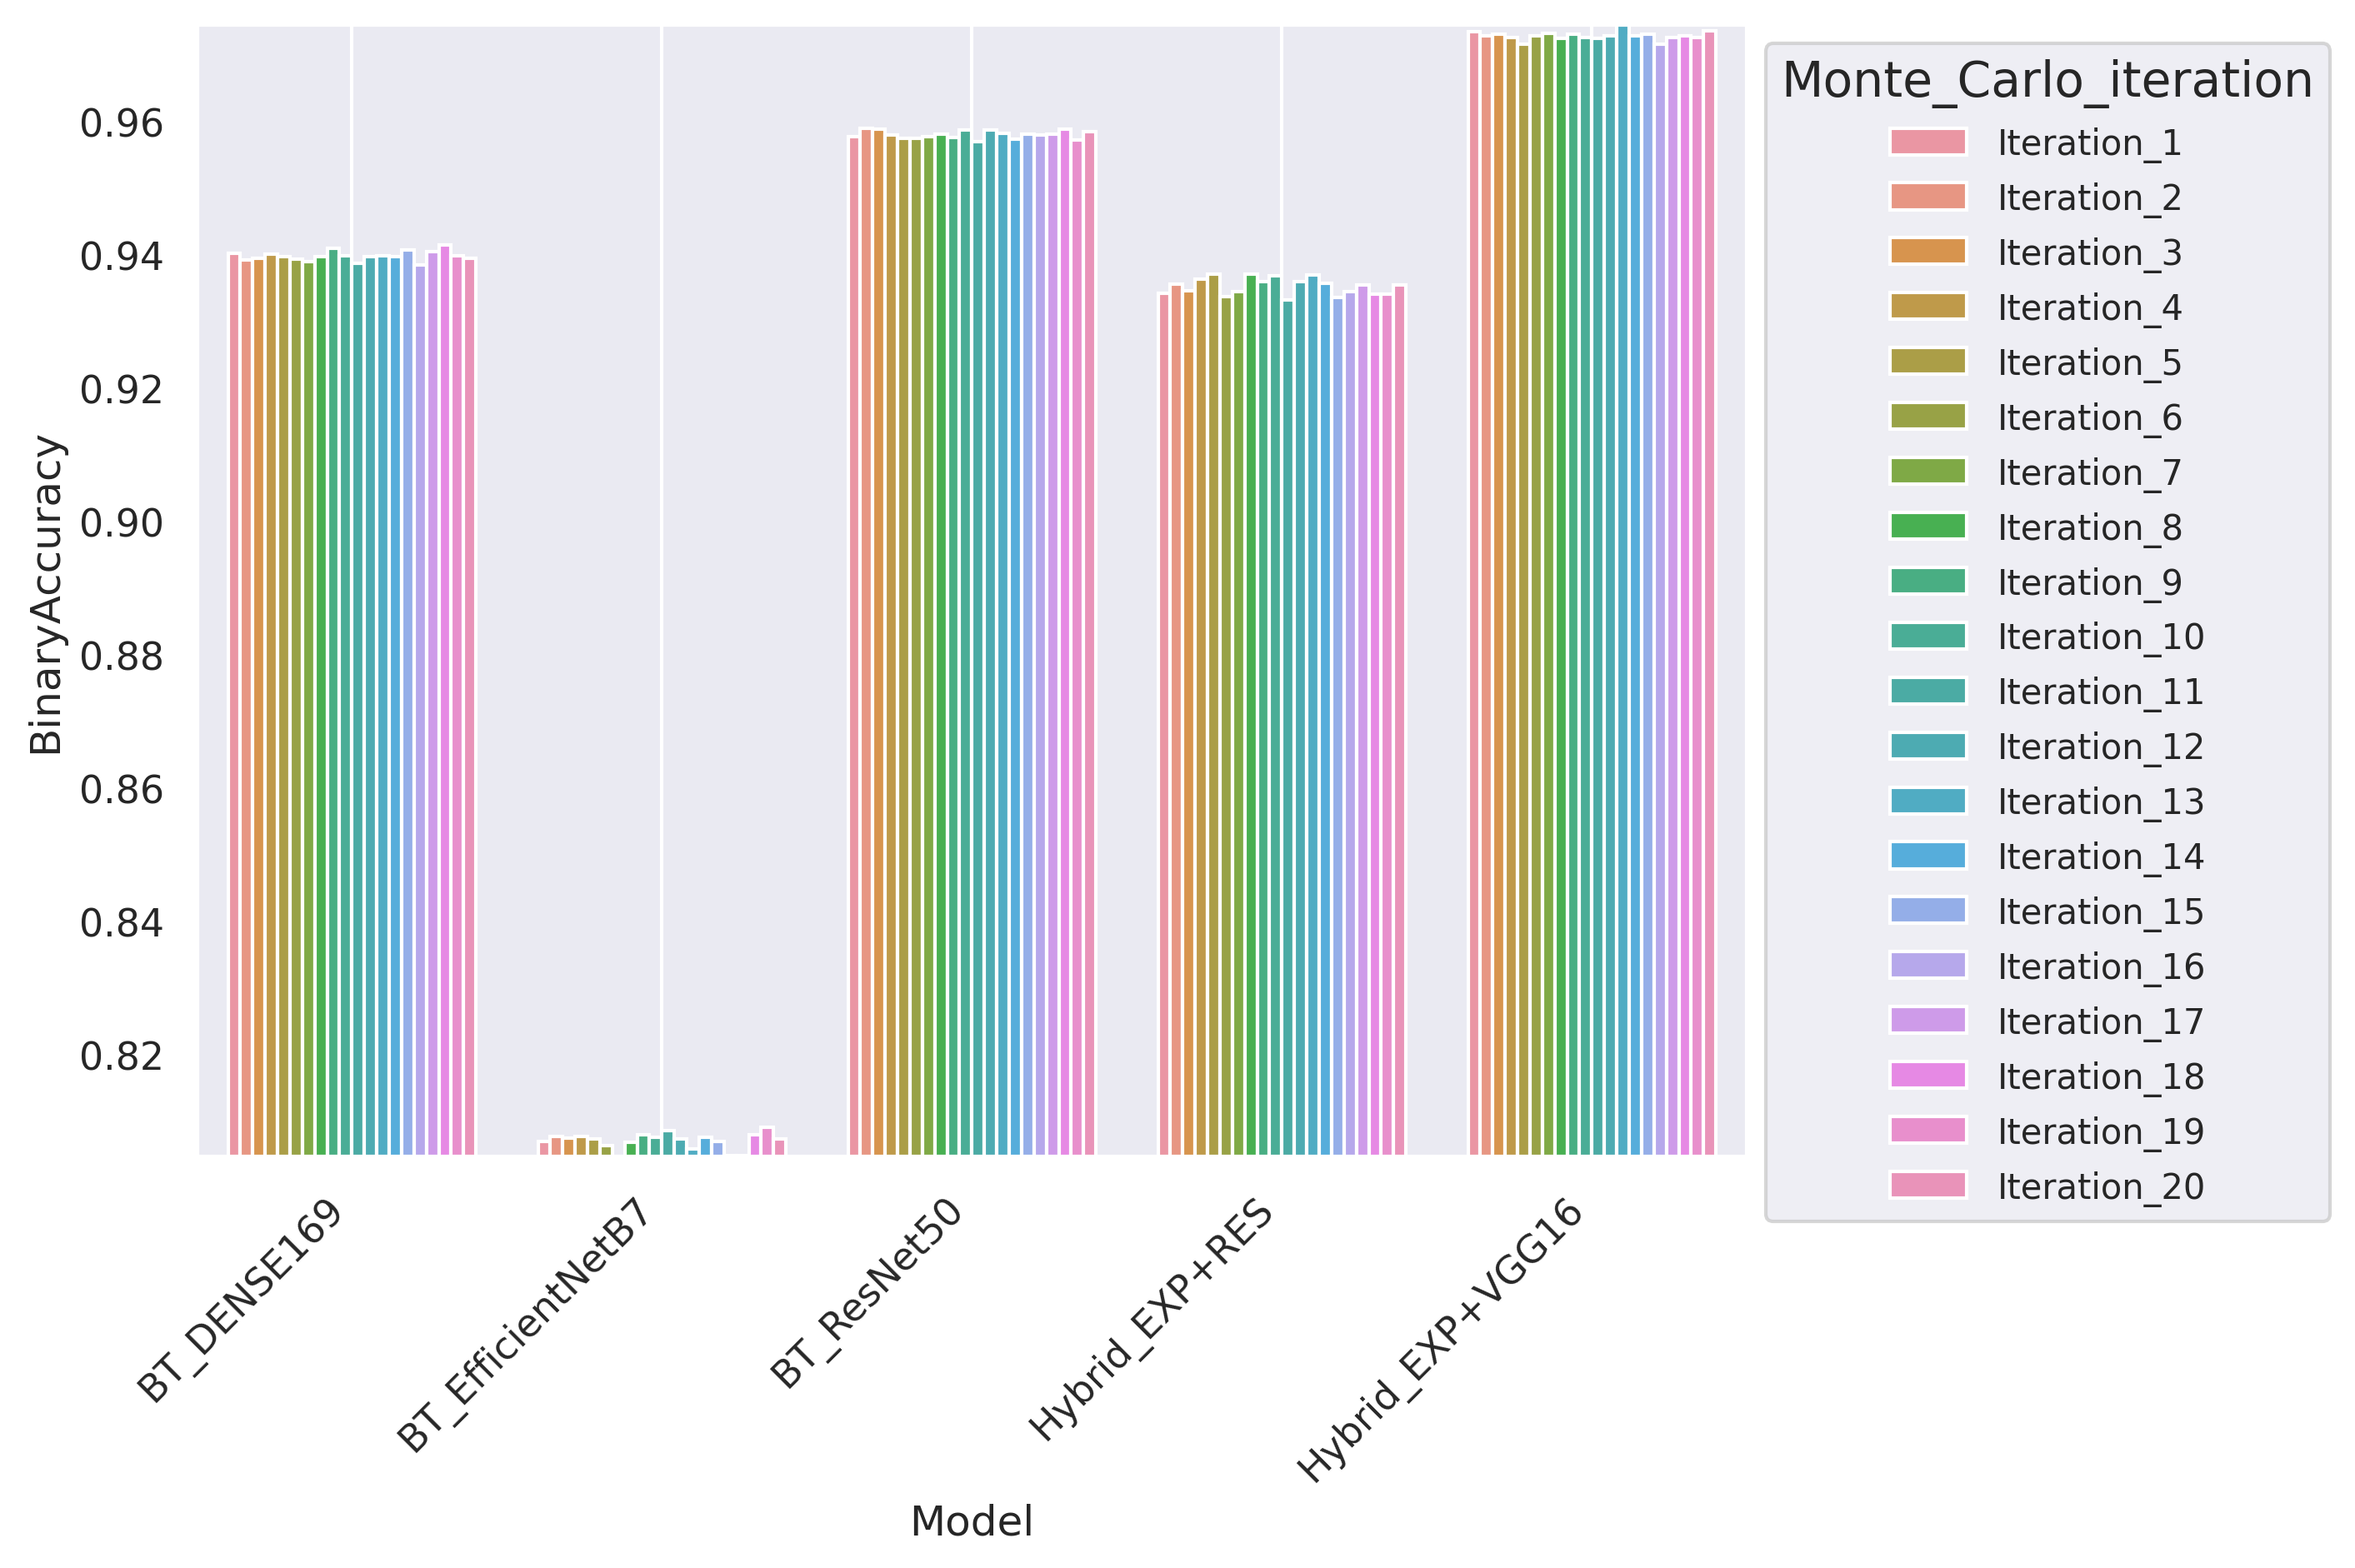

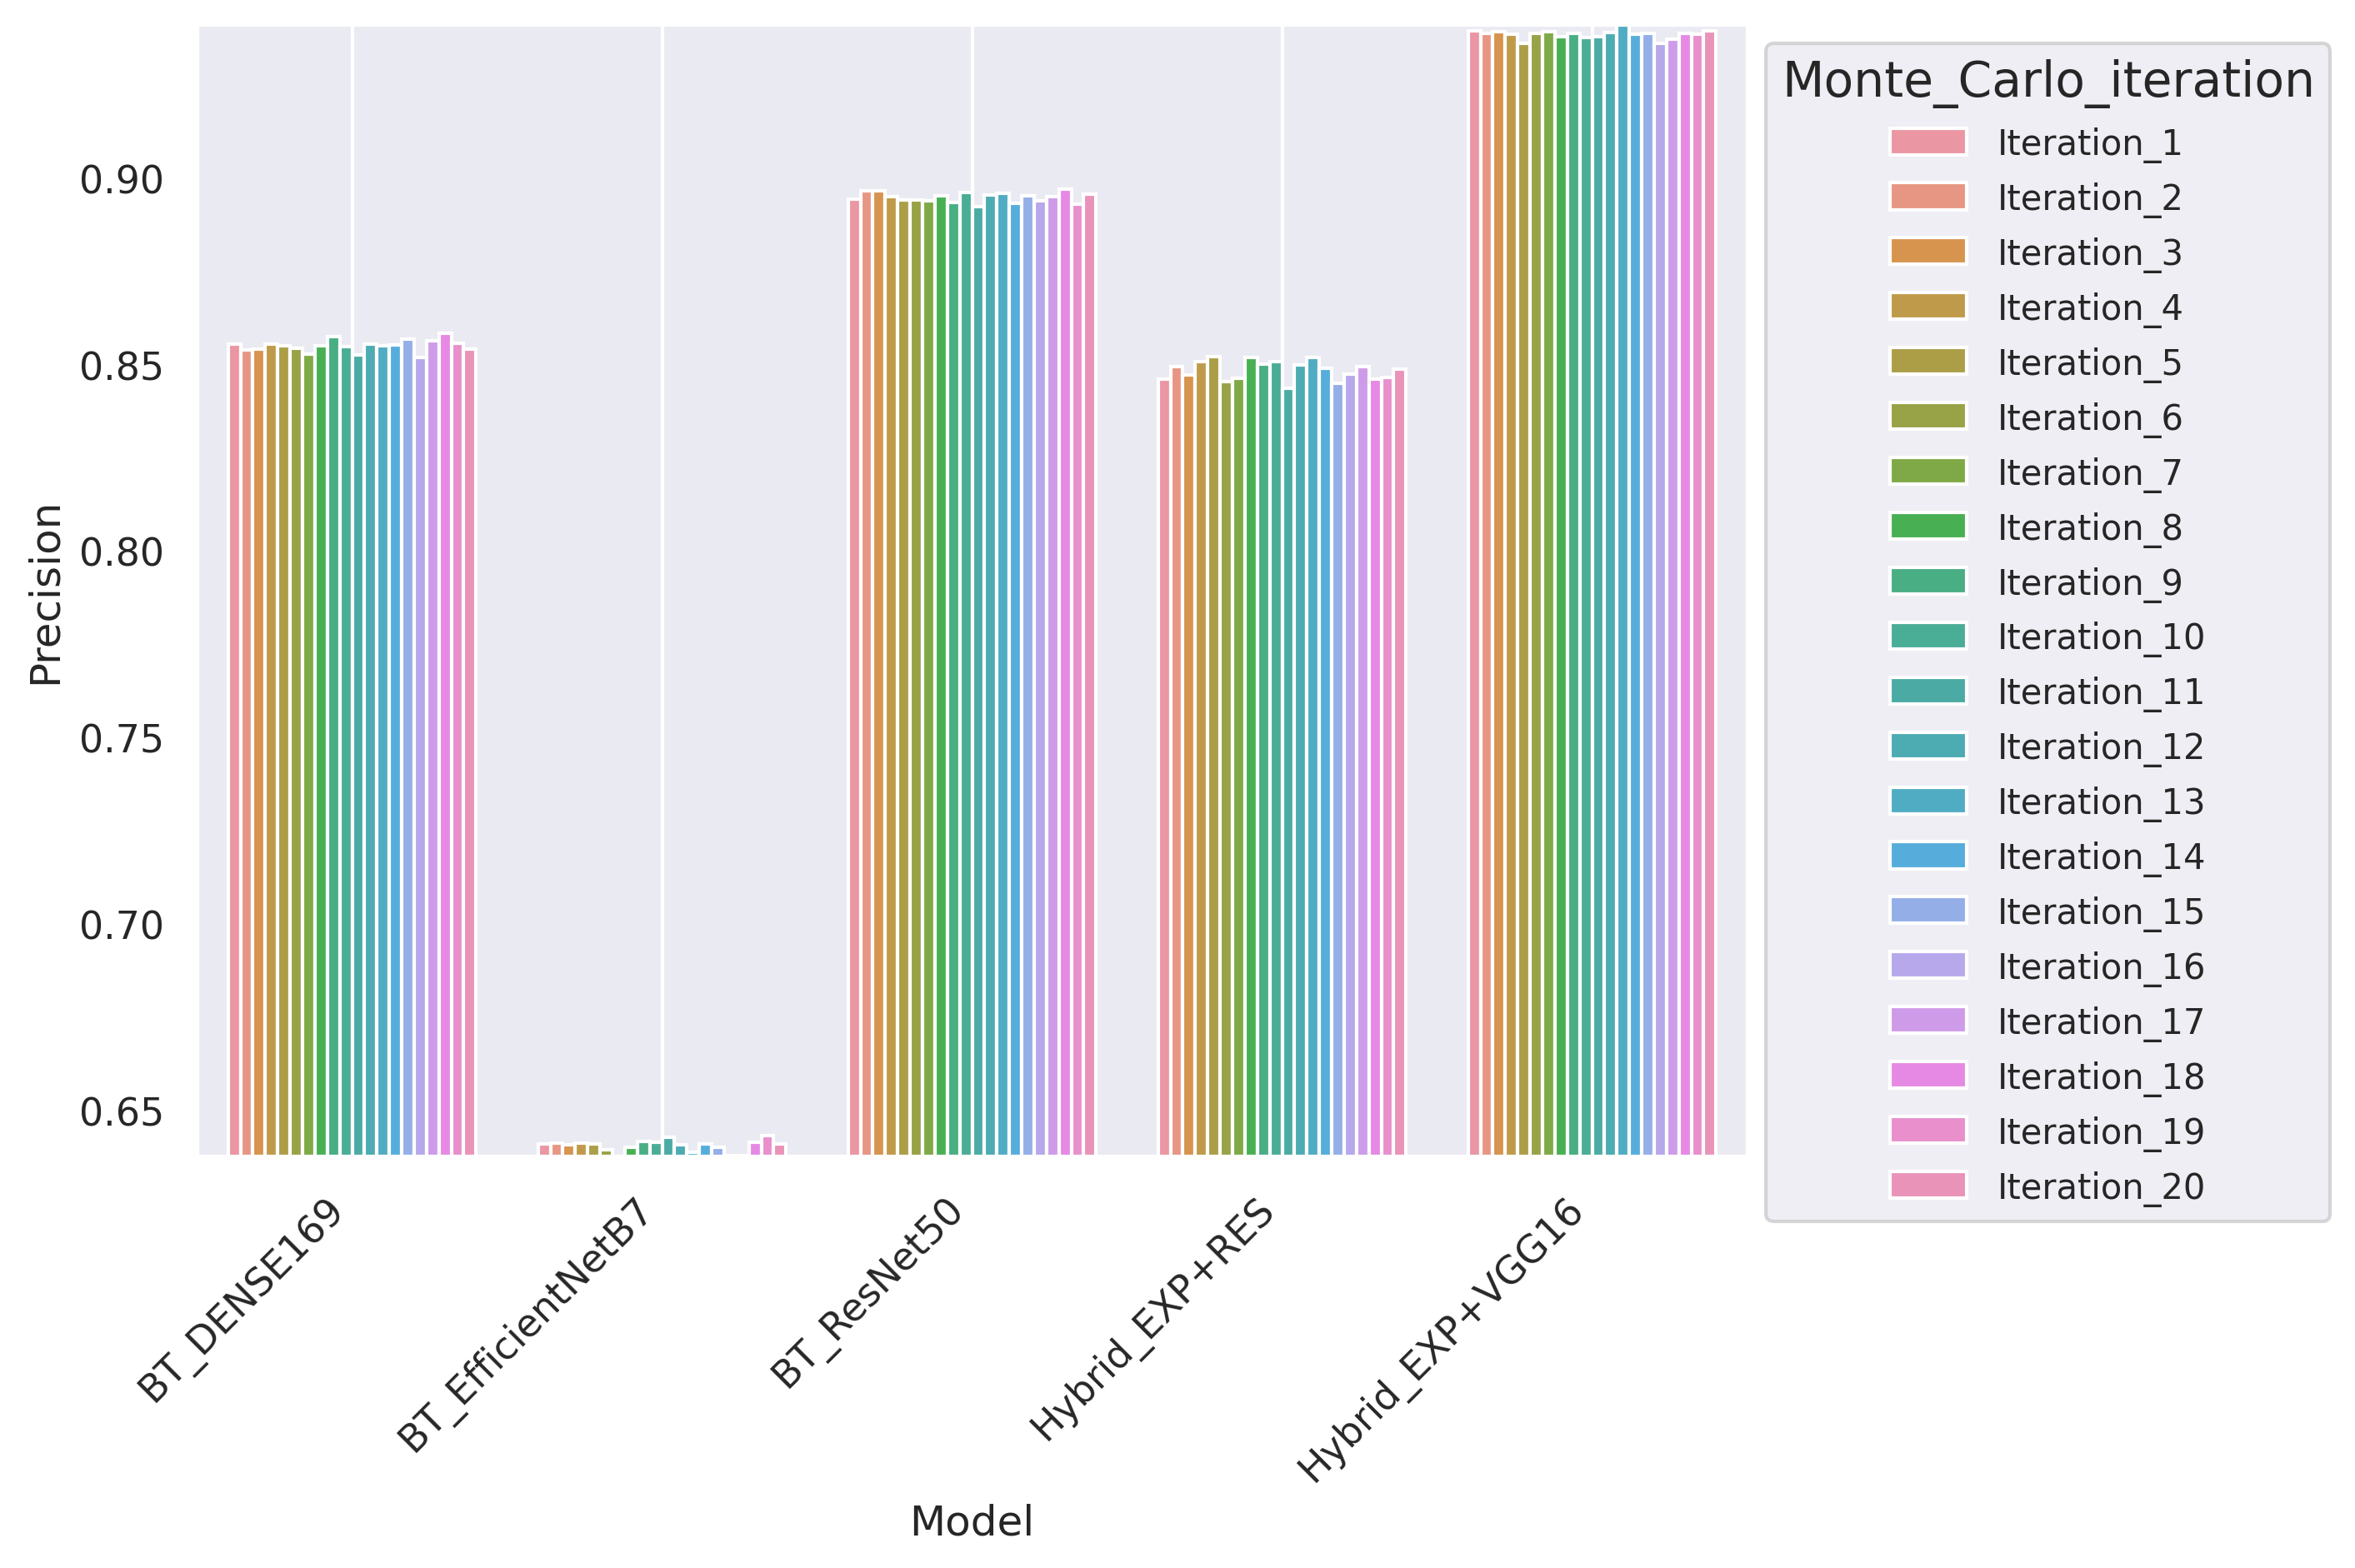

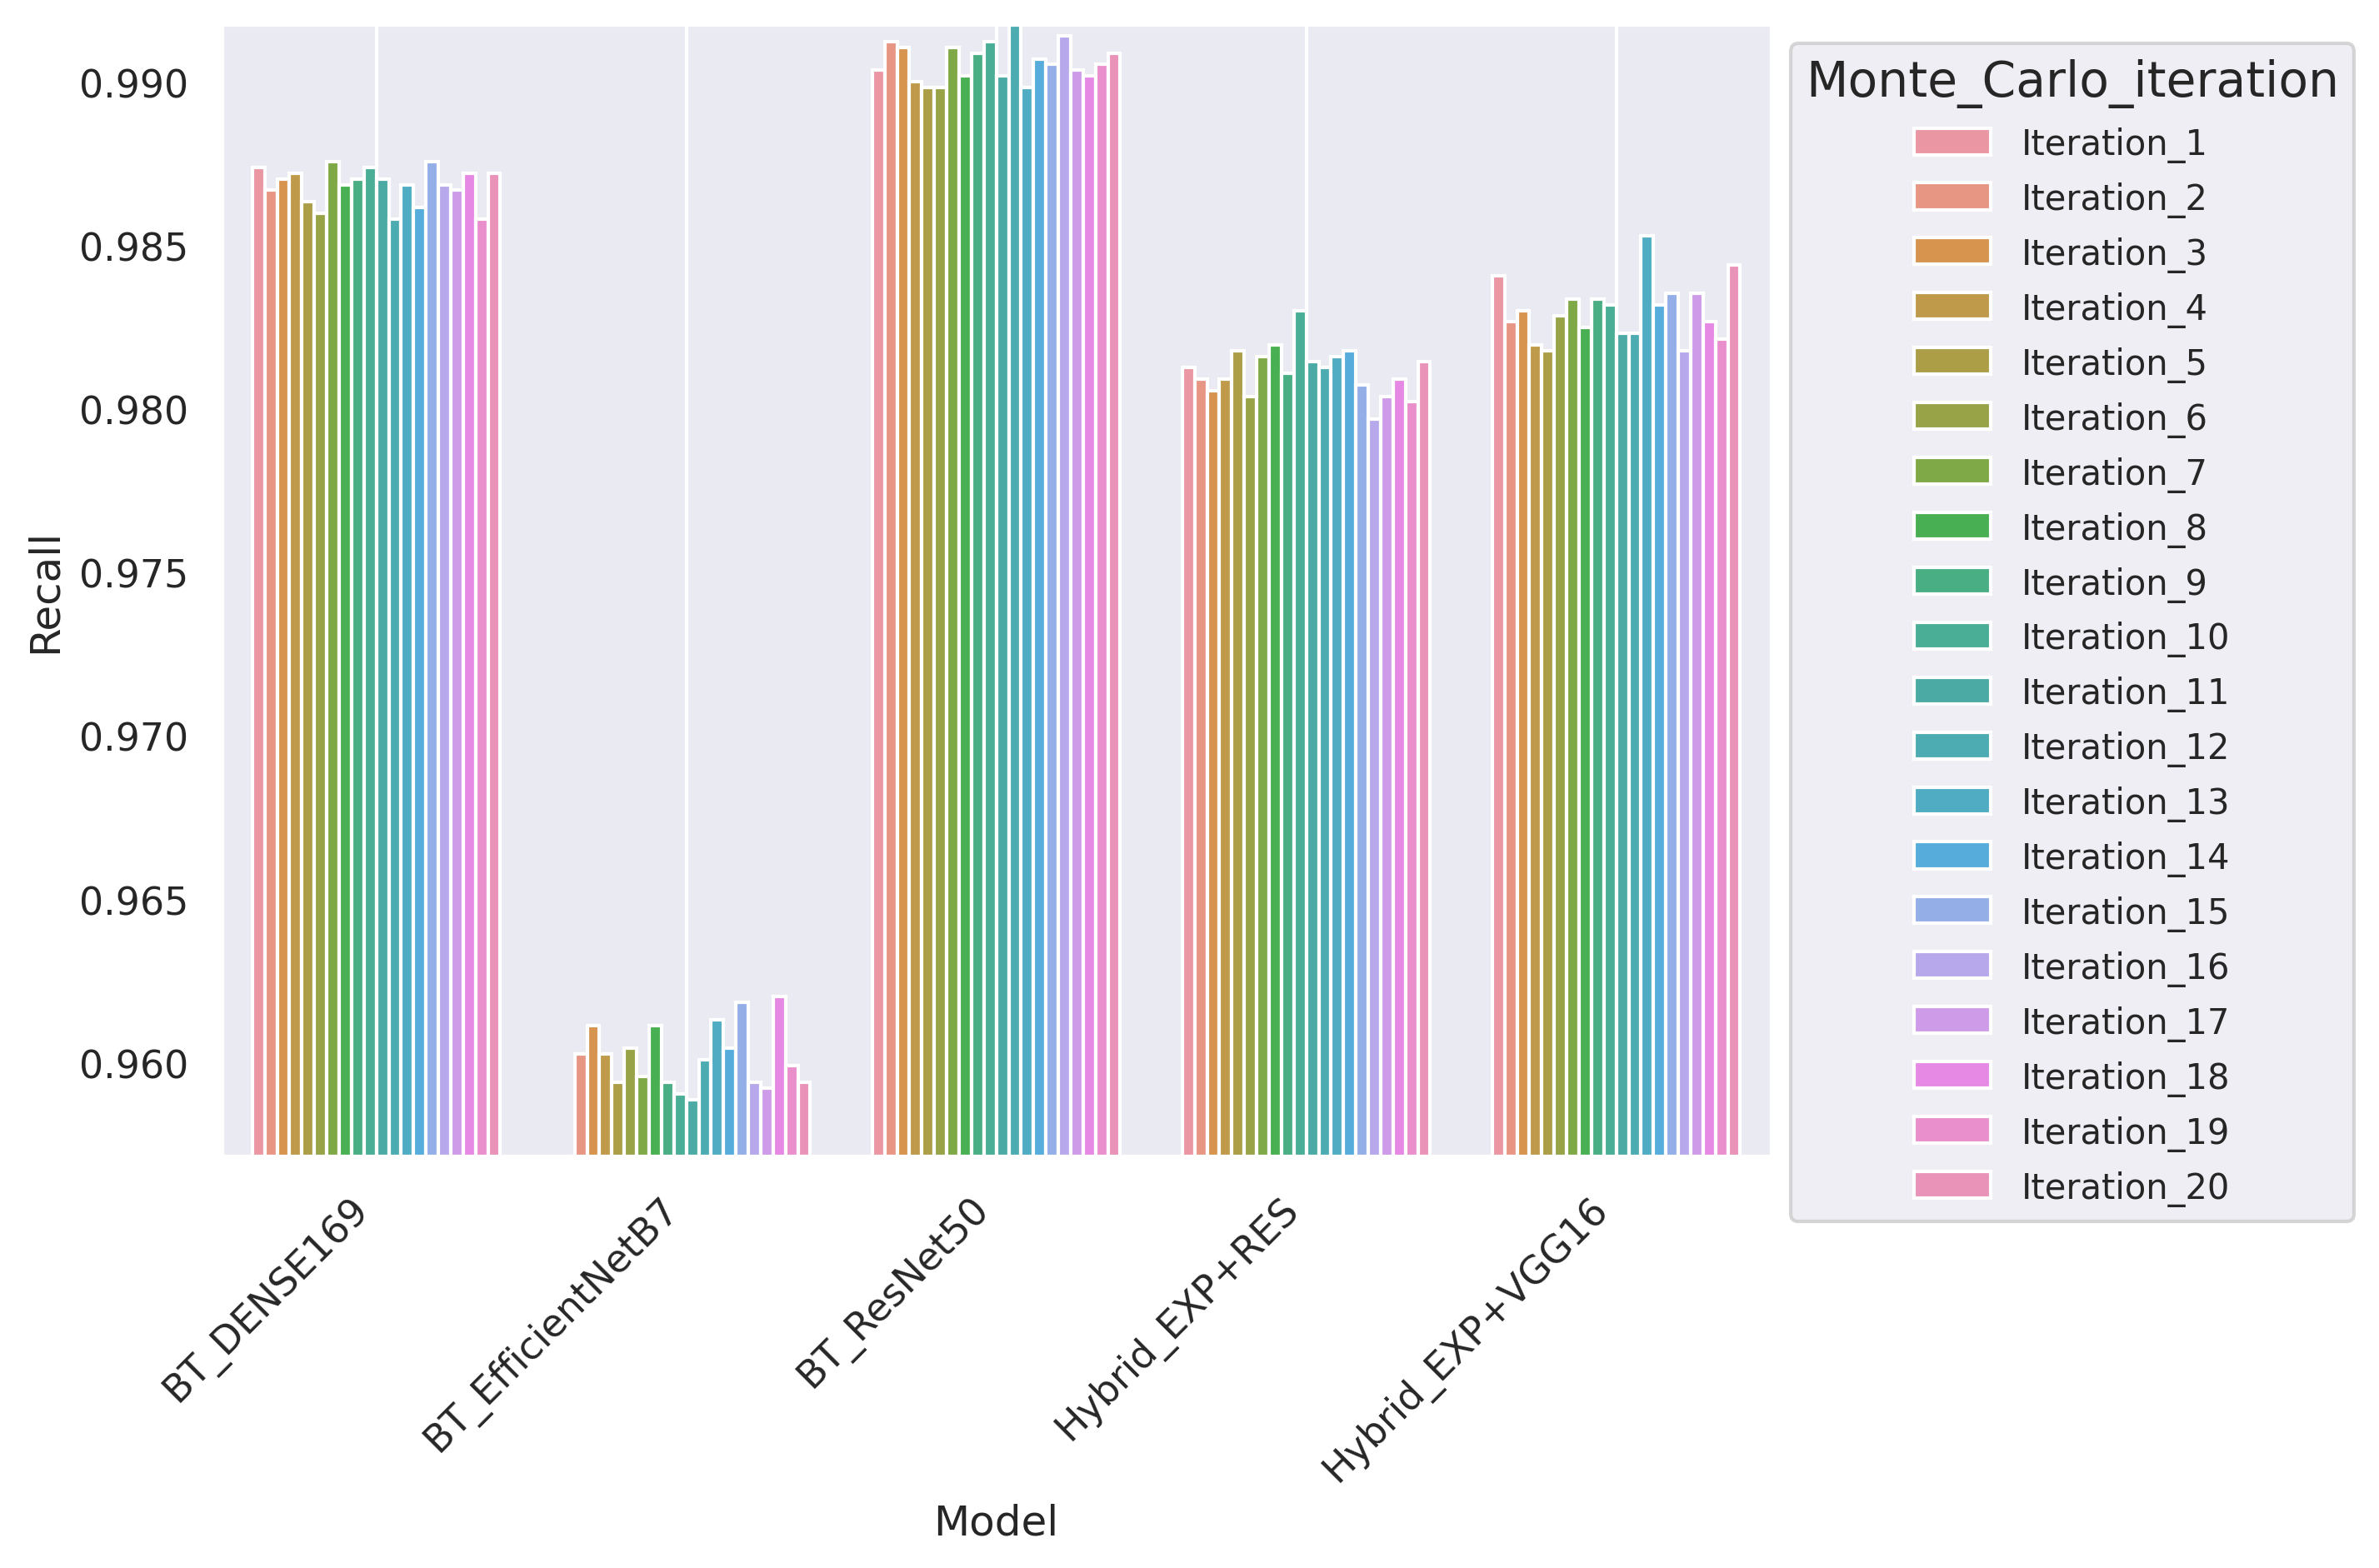

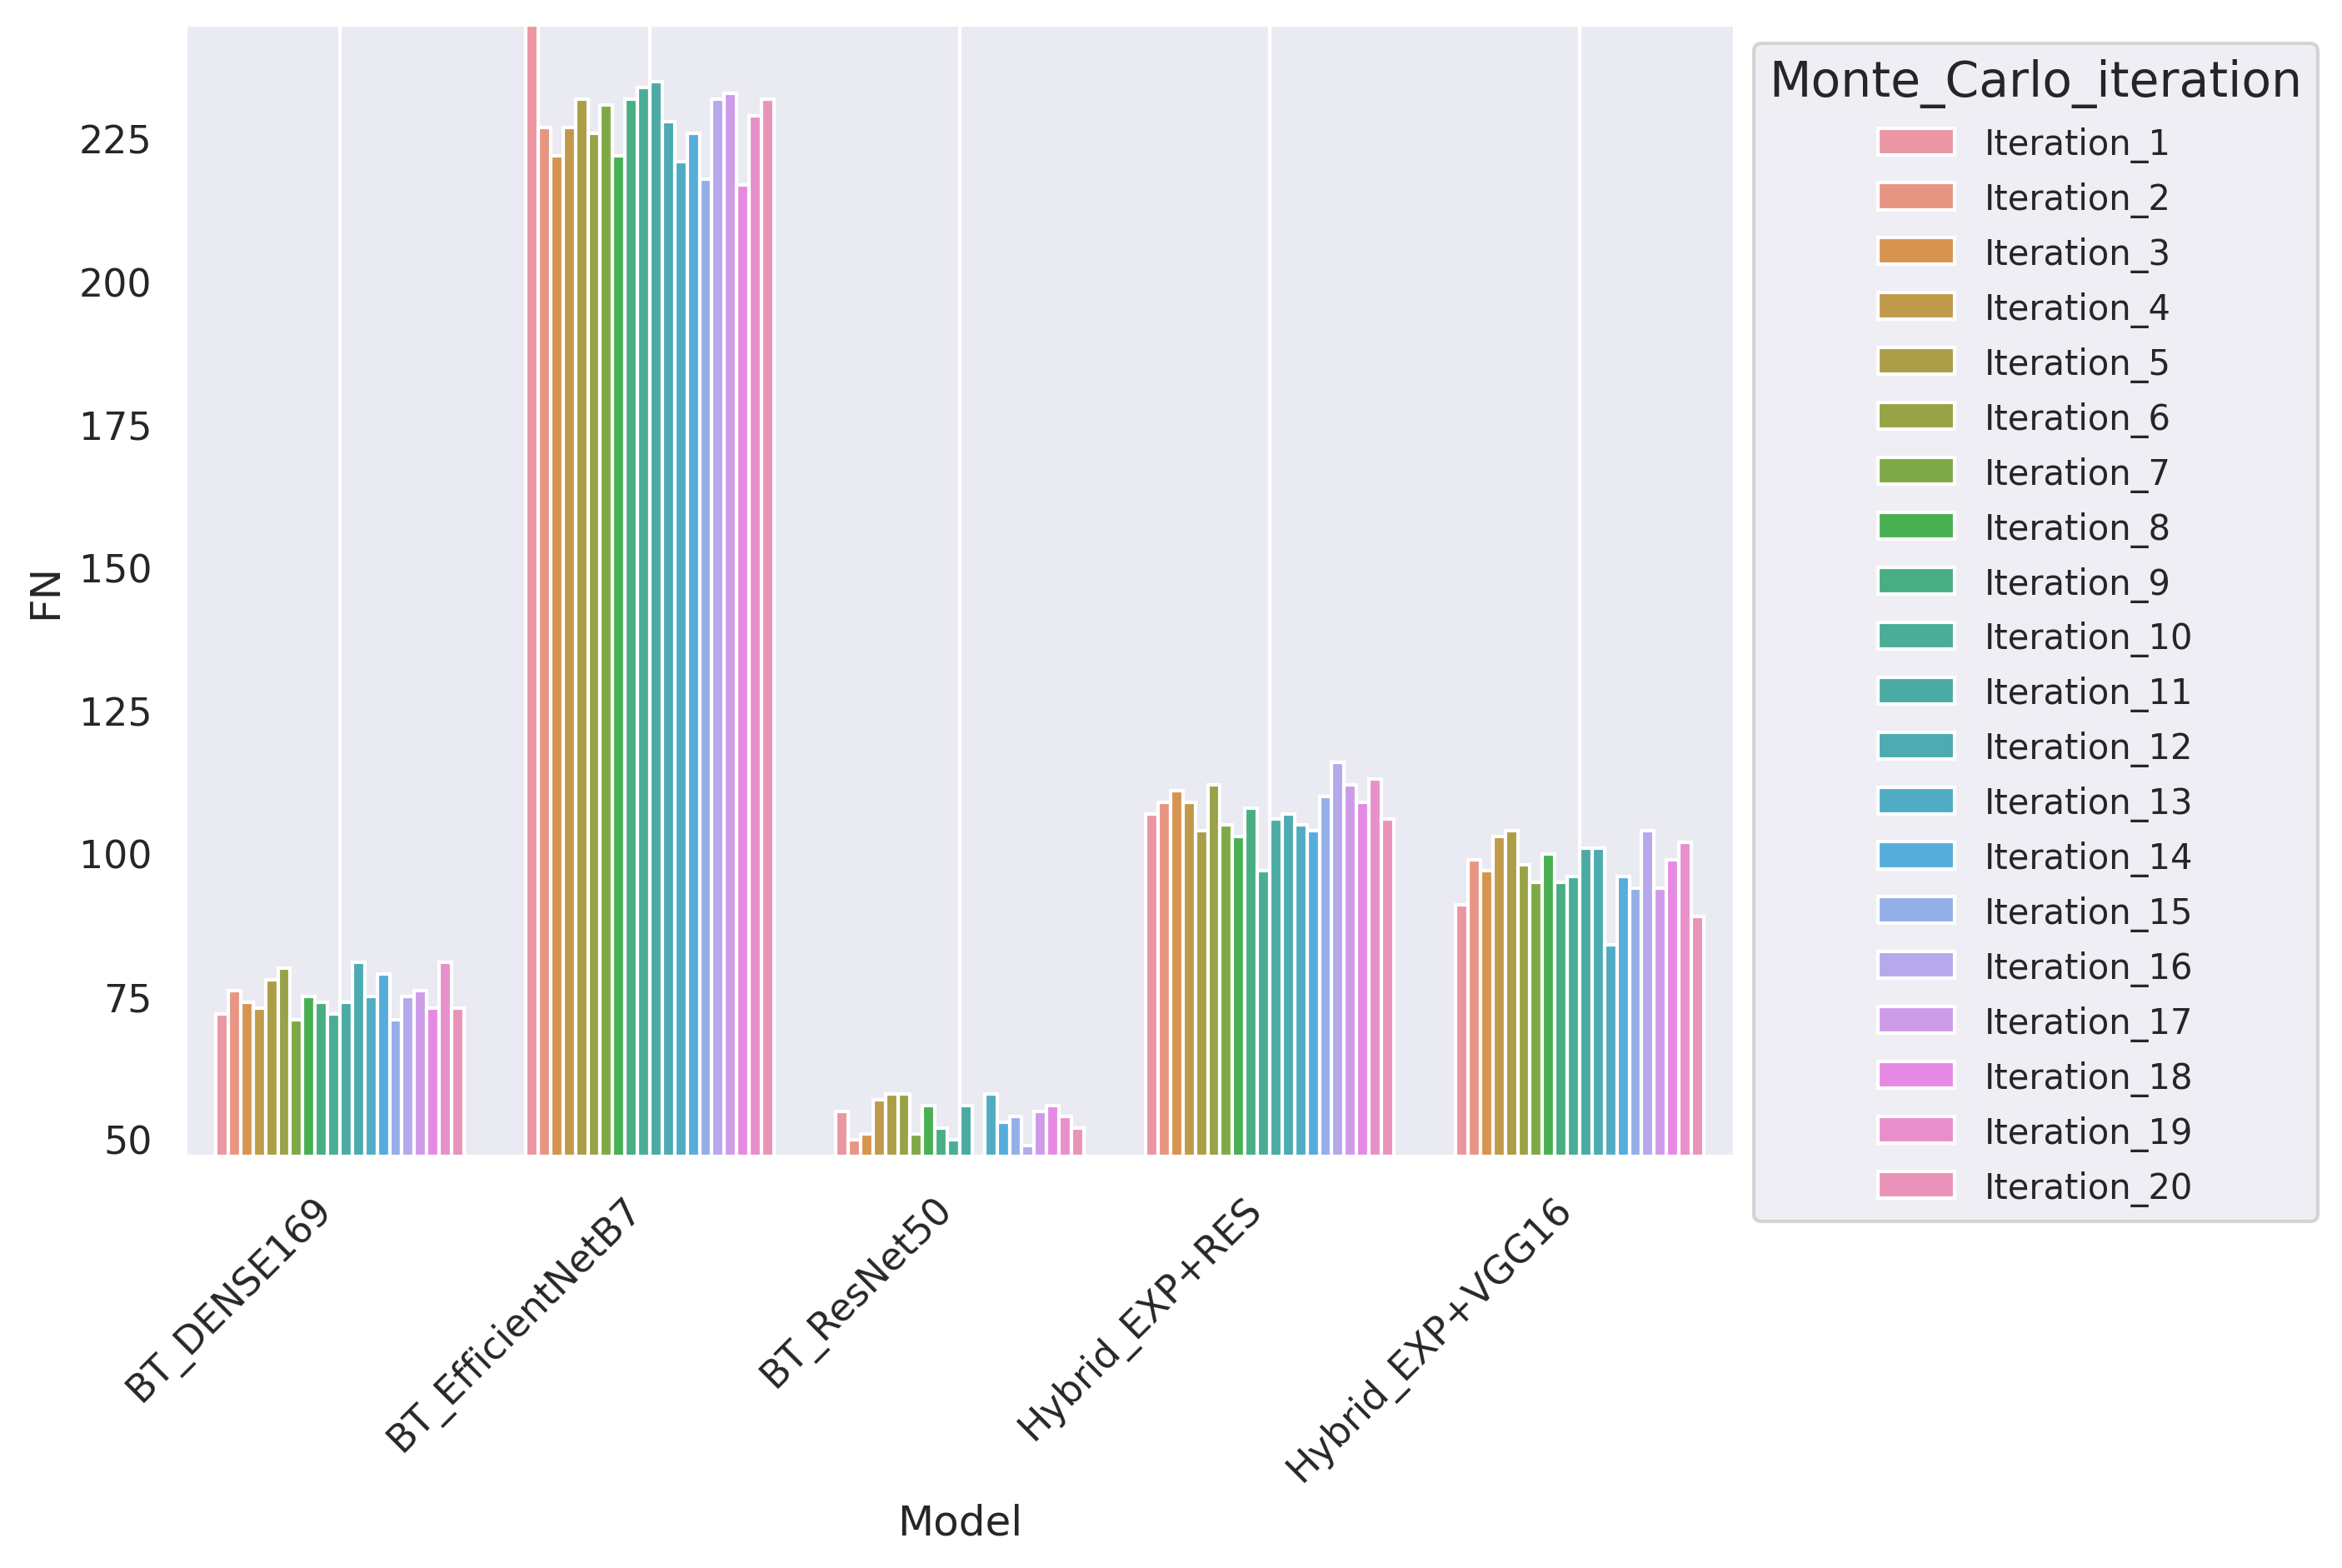

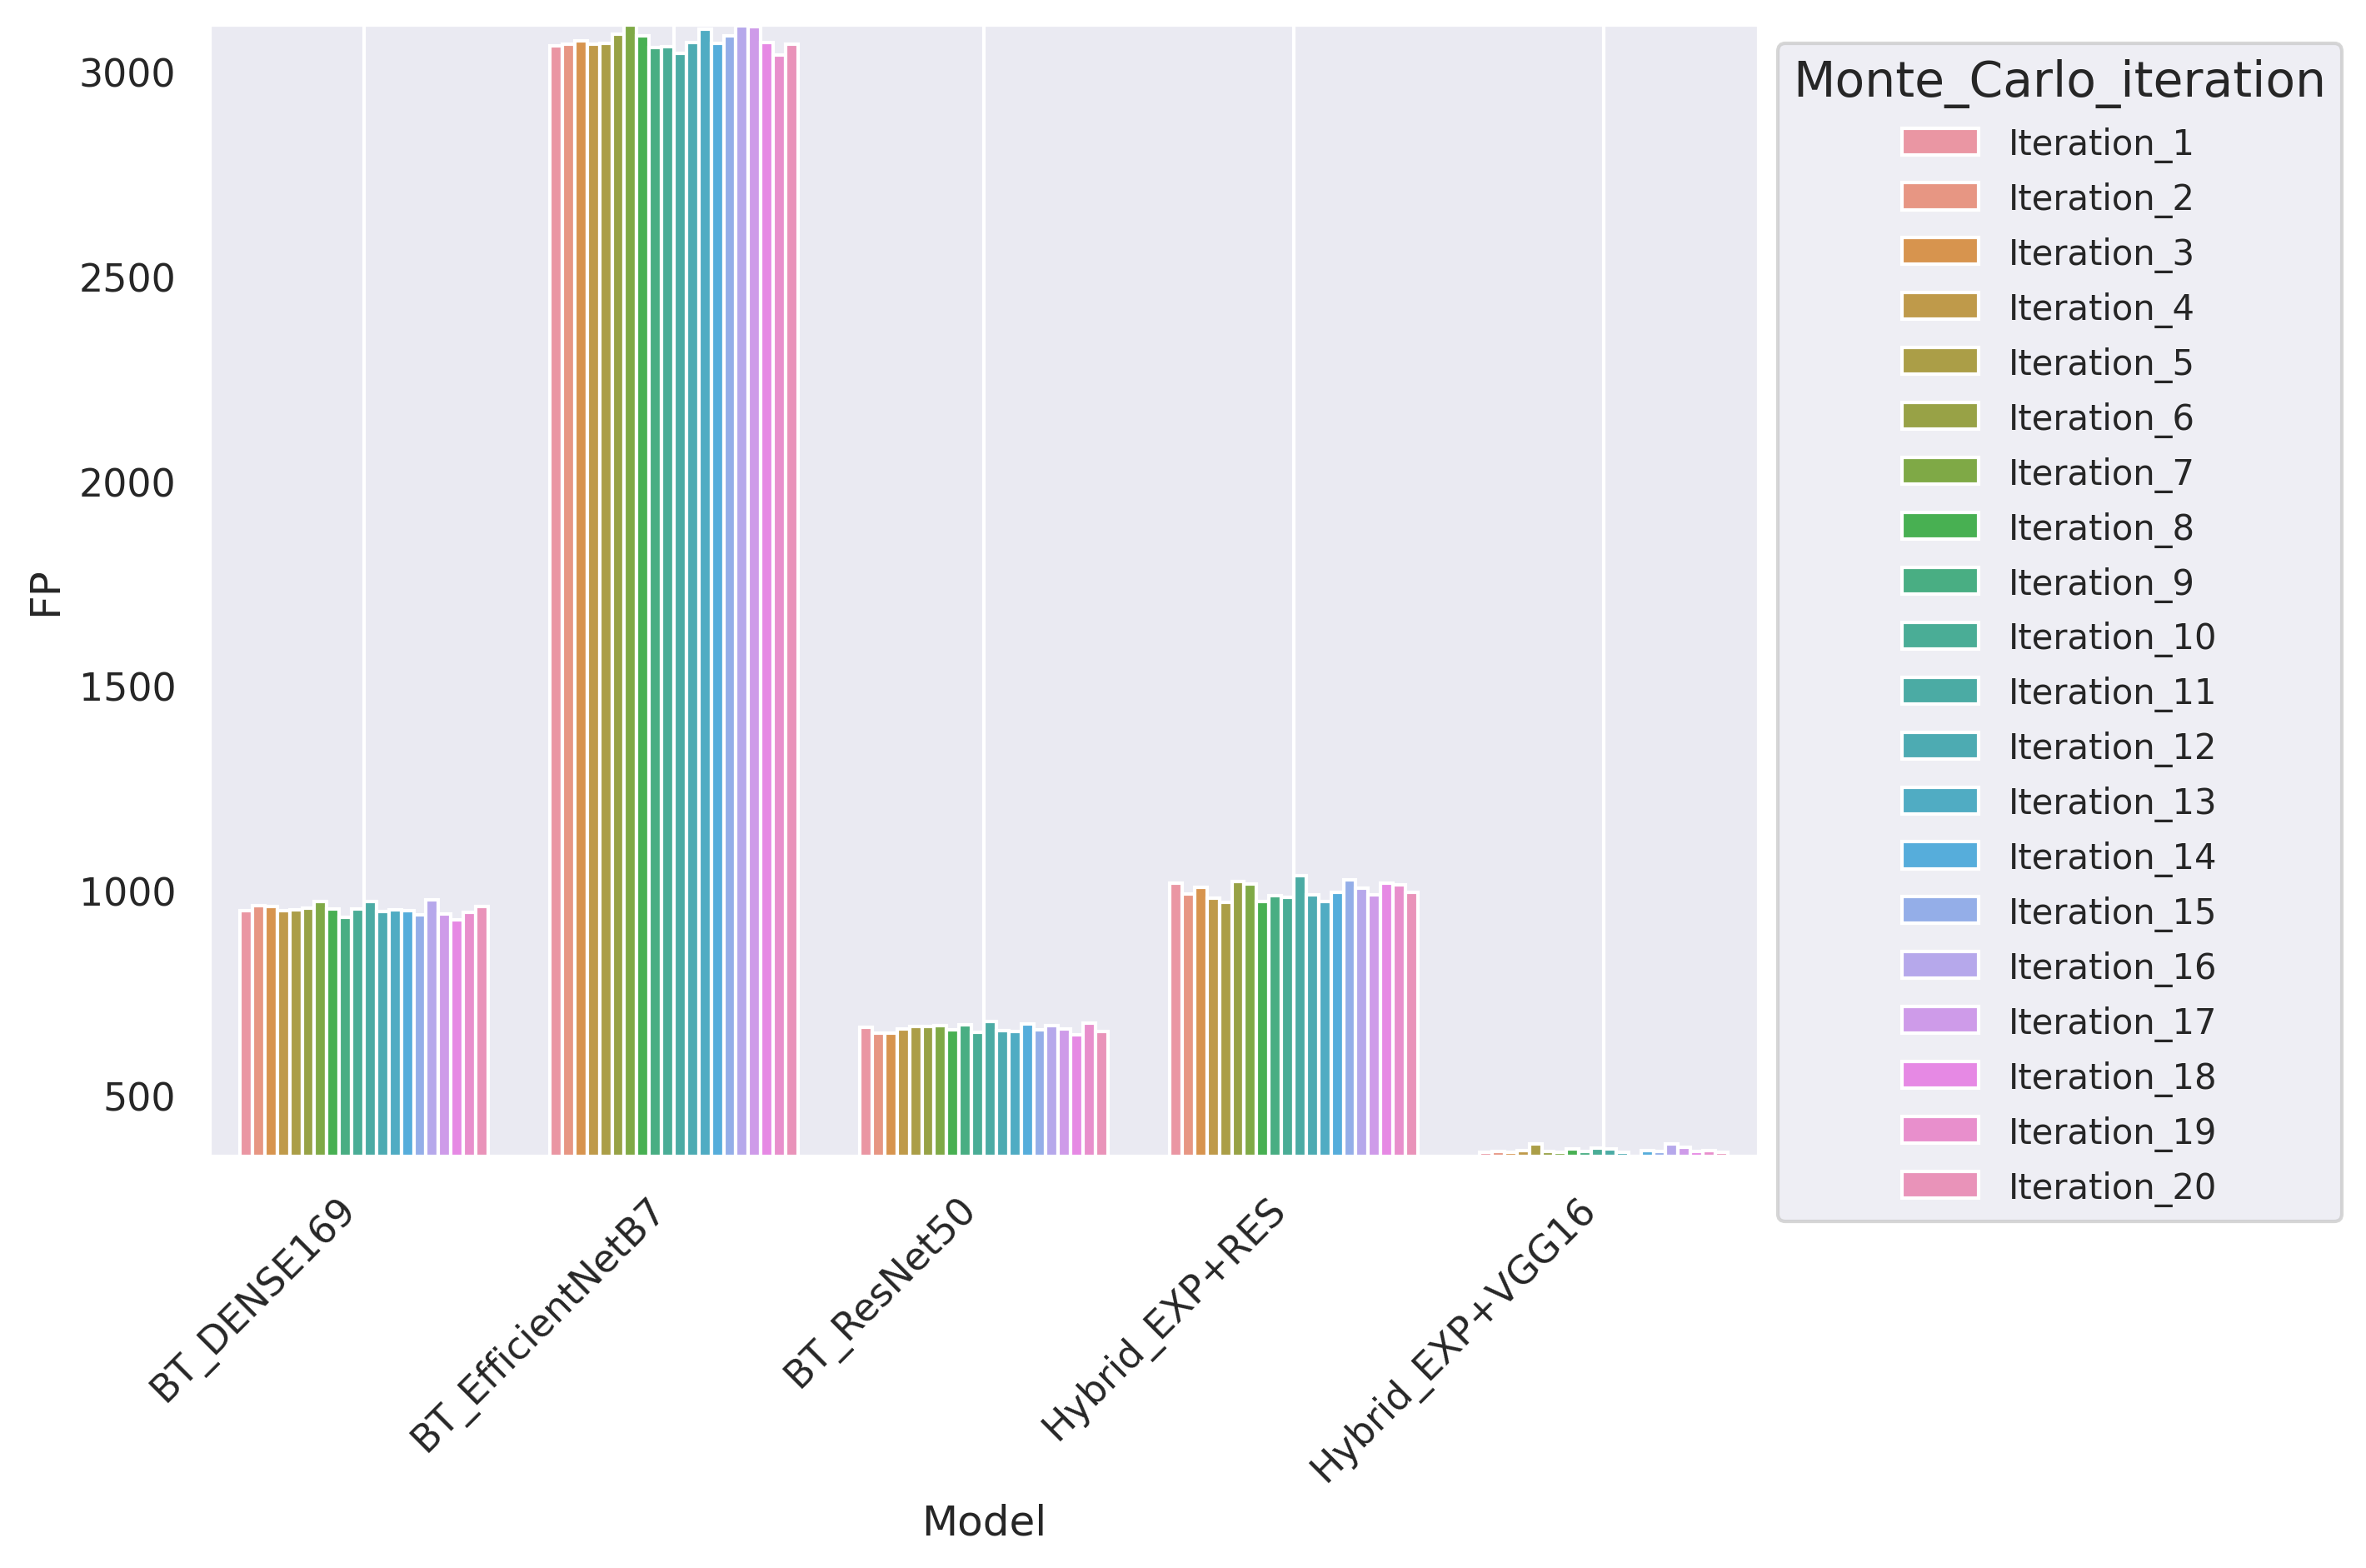

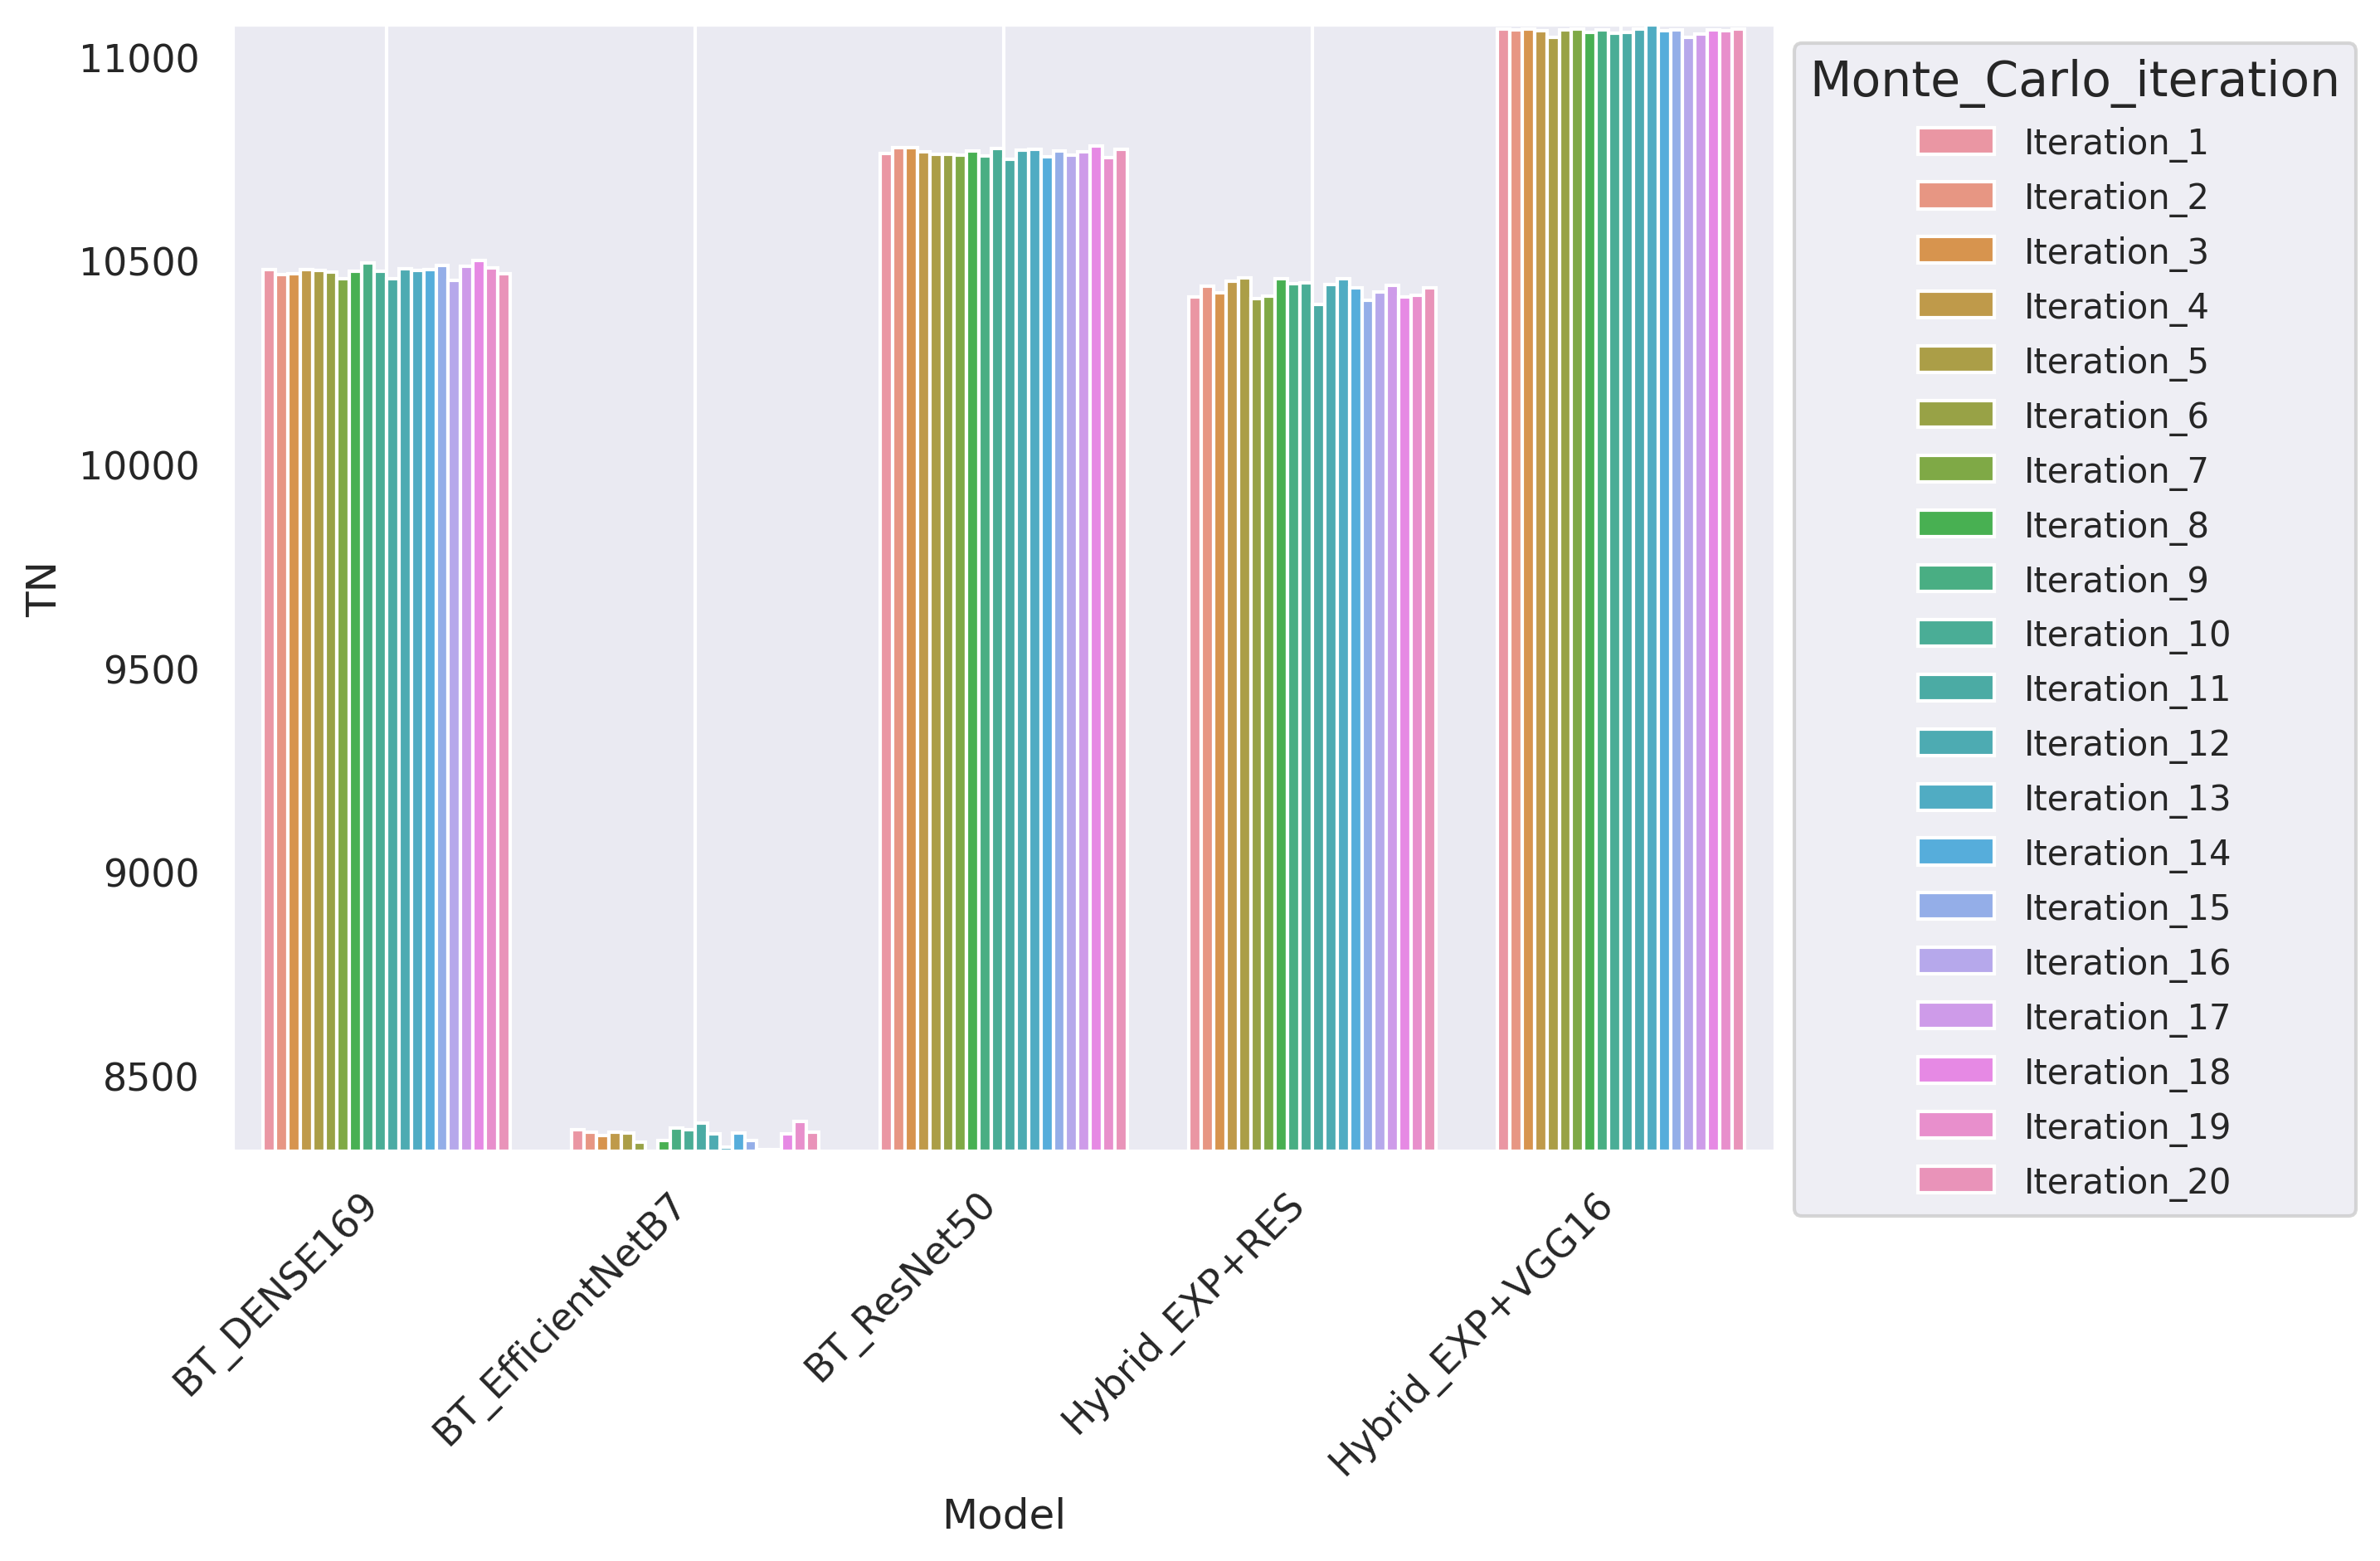

KeyboardInterrupt: 

In [38]:
from matplotlib.pyplot import figure

for param in ['accuracy', 'BinaryAccuracy', 'Precision', 'Recall', 'FN', 'FP', 'TN', 'TP', 'AUC'
]:
    figure(figsize=(8, 6), dpi=300)
    box=sns.barplot(data=montedf, x="Model", y=param, hue="Monte_Carlo_iteration")
    sns.move_legend(box, "upper left", bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45, ha='right')
    plt.setp(box.get_legend().get_texts(), fontsize='10')
    plt.setp(box.get_legend().get_title(), fontsize='14')
    plt.ylim([min(montedf[param]),max(montedf[param])])
    plt.grid()
    plt.savefig('CV_Bar_mean_'+param+'.jpg')
    plt.show()

In [ ]:
!zip -r BT_CV.zip ./